# 라이브러리 import

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from glob import glob
import os, random, time, gc, warnings

from tqdm import tqdm_notebook

import lightgbm as lgbm
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import RFECV

from sklearn.cluster import KMeans

from datetime import datetime

from math import sqrt
import io

warnings.filterwarnings('ignore')

pd.set_option('max_columns', 500)
pd.set_option('max_rows', 500)

%matplotlib inline

# 데이터 전처리

## 데이터 확인

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/05031(0제거).csv')
print(len(df))
df.head()

385


,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
0,1,c37ba1af,1,1,40183.00004,1.40,40334.00003,40144.00003,1.85,40337.00001,40361.00003,2.87,40372.00004
1,2,c37ba1af,1,1,40396.99997,0.51,40486.00000,0.00000,5.41,0.00000,40513.00000,5.70,40523.00003
2,3,c37ba1af,1,1,0.00000,1.76,0.00000,40758.99998,0.59,40831.00004,40847.00003,0.08,40851.00000
3,4,c37ba1af,1,1,0.00000,5.23,0.00000,40910.99996,5.91,0.00000,40960.99999,1.79,40963.99997
4,5,c37ba1af,1,1,0.00000,1.74,0.00000,41022.00003,3.78,41031.99996,41047.00004,0.28,41056.99998


In [ ]:
# #데이터 불러오기(로컬 환경일때)
# df=pd.read_csv('D:\\test2\\test3\\2021_04_10_data_set(used by table_6)(0제거)_conwip_20.csv',
#                 #names=['id','Uid','completed','CycleNumber','MCIn1',
#                 #       'MC1PrTime','MCOut1','MCIn2','MC2PrTime','MCOut2','MCIn3','MC3PrTime','MCOut3']
#                )
# print(df.shape)
# df.head()

In [ ]:
# 데이터 conwip 파악
import collections

list123123123 = []
for i in df['Uid']:
    list123123123.append(i)
    
dict={}
a=list(set(list123123123))
test = a
dict=collections.Counter(list123123123)
conwip = len(a)
print(dict, '\n\nconwip: ',conwip)

Counter({'c37b81a6': 25, 'c37b7e02': 23, 'c37b82d7': 23, 'c37b877b': 23, 'c37b770b': 22, 'c37b9987': 22, 'c37b7970': 21, 'c37b9e2f': 21, 'c37b9728': 20, 'c37b9aab': 20, 'c37b7a6e': 19, 'c37ba1af': 18, 'c37b81a9': 18, 'c37b75d8': 18, 'c37b7dfe': 17, 'c37b997a': 16, 'c37b84f4': 16, 'c37ba1b6': 15, 'c37b83cb': 14, 'c37ba2e1': 14}) 

conwip:  20


In [ ]:
'''
# 시간이 하나도 찍히지 않은 제품 식별 후 삭제
df_idx_1 = df[(df['MCIn1'] == '00:00:00') & (df['MCOut1'] == '00:00:00') & (df['MCIn2'] == '00:00:00') & (df['MCOut2'] == '00:00:00') & (df['MCIn3'] == '00:00:00') & (df['MCOut3'] == '00:00:00')].index
# len(df_idx)
df_sample_1 = df.drop(df_idx_1)
len(df_sample_1)
'''

# 시간이 하나도 찍히지 않은 제품 식별 후 삭제
df_idx_1 = df[(df['MCIn1'] == 0) & (df['MCOut1'] == 0) & (df['MCIn2'] == 0) & (df['MCOut2'] == 0) & (df['MCIn3'] == 0) & (df['MCOut3'] == 0)].index
# len(df_idx)
df_sample_1 = df.drop(df_idx_1)
len(df_sample_1)

385

In [ ]:
df = df_sample_1.copy()

In [ ]:
df.describe()

,id,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
count,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000,385.000000
mean,338.309091,0.974026,3.218182,27990.215584,3.727896,27274.142857,38349.633765,3.837688,36527.490909,42010.628571,3.854338,41797.810389
std,195.425032,0.159265,1.542516,20413.662928,3.295663,20694.326852,13362.889874,3.765901,15491.884815,6378.620036,3.742590,7056.237237
min,1.000000,0.000000,1.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000,0.000000,0.010000,0.000000
25%,113.000000,1.000000,1.000000,0.000000,1.210000,0.000000,40777.000040,1.090000,40516.999980,41275.999960,1.100000,41248.999960
50%,378.000000,1.000000,4.000000,41162.999990,2.850000,41122.999990,42660.000000,2.670000,42615.000030,42876.999990,2.680000,42903.999990
75%,507.000000,1.000000,5.000000,43546.000030,5.240000,43565.999990,44280.000000,5.410000,44279.000010,44410.000030,5.540000,44382.000040
max,623.000000,1.000000,5.000000,45790.000010,15.850000,45803.000020,45786.000040,27.250000,45806.000000,45888.999980,25.240000,45892.999960


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 144 entries, 0 to 143
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   144 non-null    int64  
 1   id           144 non-null    int64  
 2   Uid          144 non-null    object 
 3   completed    144 non-null    int64  
 4   CycleNumber  144 non-null    int64  
 5   MCIn1        144 non-null    float64
 6   MC1Prtime    144 non-null    float64
 7   MCOut1       144 non-null    float64
 8   MCIn2        144 non-null    float64
 9   MC2Prtime    144 non-null    float64
 10  MCOut2       144 non-null    float64
 11  MCIn3        144 non-null    float64
 12  MC3Prtime    144 non-null    float64
 13  MCOut3       144 non-null    float64
dtypes: float64(9), int64(4), object(1)
memory usage: 16.9+ KB


In [ ]:
#열별로 결측값 개수 확인
count1=0

for i in df_dropped_3:
    count2 = 0
    for j in df_dropped_3[i]:
        if j == 0:
            count2+=1
    print('-'*50)
    print(i,"열의 결측값 개수:",count2)
    count1+=count2
    
print('-'*50)
print('전체 결측값 개수:',count1)

--------------------------------------------------
Unnamed: 0 열의 결측값 개수: 0
--------------------------------------------------
id 열의 결측값 개수: 0
--------------------------------------------------
Uid 열의 결측값 개수: 0
--------------------------------------------------
completed 열의 결측값 개수: 19
--------------------------------------------------
CycleNumber 열의 결측값 개수: 0
--------------------------------------------------
MCIn1 열의 결측값 개수: 67
--------------------------------------------------
MC1Prtime 열의 결측값 개수: 1
--------------------------------------------------
MCOut1 열의 결측값 개수: 68
--------------------------------------------------
MCIn2 열의 결측값 개수: 18
--------------------------------------------------
MC2Prtime 열의 결측값 개수: 0
--------------------------------------------------
MCOut2 열의 결측값 개수: 40
--------------------------------------------------
MCIn3 열의 결측값 개수: 17
--------------------------------------------------
MC3Prtime 열의 결측값 개수: 0
--------------------------------------------------
MCOut3 열의

## 이상치 제거 & 결측치 채우기

### 함수 선언

In [ ]:
#열의 값 중 시간 순서가 맞지 않는 값이 있는지 확인하는 함수 선언
def check_col_order(df,col): #데이터 프레임이랑 열의 이름을 인자로 받음
    count=0
    print('-'*70)
    print('열 내 순서 확인 시작')
    for i,j in enumerate(df[col]):
        if i == len(df)-1:
            print('마지막 행(',i,')은 비교불가')
            break
        if (df[col][i] != 0) & (df[col][i+1] != 0) :
            if df[col][i] >= df[col][i+1]:
                print('인덱스:',i)
                count+=1
    print('이상값:',count)
    print('열 내 순서 확인 완료')
    print('-'*70)
    
    
    
#열의 값 중 시간 순서가 맞지 않는 값을 제거하는 함수 선언
def check_col_order_del(df,col): #데이터 프레임이랑 열의 이름을 인자로 받음
    print('-'*70)
    print('제거 시작')
    for i,j in enumerate(df[col]):
        if i == len(df)-1:
            print('마지막 행(',i,')은 비교불가')
            break
        if (df[col][i] != 0) & (df[col][i+1] != 0):
            if df[col][i] >= df[col][i+1]:
                print('인덱스-',i,'제거')
                df[col][i] = 0
    print('제거 완료')
    print('-'*70)
    
    
    
#열의 값 중 시간 순서가 맞지 않는 값의 다음 행을 제거하는 함수 선언
def check_col_order_del2(df,col): #데이터 프레임이랑 열의 이름을 인자로 받음
    print('-'*70)
    print('제거 시작')
    for i,j in enumerate(df[col]):
        if i == len(df)-1:
            print('마지막 행(',i,')은 비교불가')
            break
        if (df[col][i] != 0) & (df[col][i+1] != 0):
            if df[col][i] >= df[col][i+1]:
                print('인덱스-',i+1,'제거')
                df[col][i+1] = 0
    print('제거 완료')
    print('-'*70)
    
    
    
#열의 값 중 시간 순서가 맞지 않는 값의 다음 행과 그 다음 행을 제거하는 함수 선언
def check_col_order_del3(df,col): #데이터 프레임이랑 열의 이름을 인자로 받음
    print('-'*70)
    print('제거 시작')
    for i,j in enumerate(df[col]):
        if i == len(df)-1:
            print('마지막 행(',i,')은 비교불가')
            break
        if (df[col][i] != 0) & (df[col][i+1] != 0):
            if df[col][i] >= df[col][i+1]:
                print('인덱스-',i+1,i+2,'제거')
                df[col][i+1] = 0
                df[col][i+2] = 0
    print('제거 완료')
    print('-'*70)
    
    
    
#열의 값 중 시간 순서가 맞지 않는 값의 다음 행과 그 다음 행과 그 다음행을 제거하는 함수 선언
def check_col_order_del4(df,col): #데이터 프레임이랑 열의 이름을 인자로 받음
    print('-'*70)
    print('제거 시작')
    for i,j in enumerate(df[col]):
        if i == len(df)-1:
            print('마지막 행(',i,')은 비교불가')
            break
        if (df[col][i] != 0) & (df[col][i+1] != 0):
            if df[col][i] >= df[col][i+1]:
                print('인덱스-',i+1,i+2,i+3,'제거')
                df[col][i+1] = 0
                df[col][i+2] = 0
                df[col][i+3] = 0
    print('제거 완료')
    print('-'*70)

    
def check_col_order_del5(df,col): #데이터 프레임이랑 열의 이름을 인자로 받음
    print('-'*70)
    print('제거 시작')
    for i,j in enumerate(df[col]):
        if i == len(df)-1:
            print('마지막 행(',i,')은 비교불가')
            break
        if (df[col][i] != 0) & (df[col][i+1] != 0):
            if df[col][i] >= df[col][i+1]:
                print('인덱스-',i+1,i+2,i+3,'제거')
                df[col][i+1] = 0
                df[col][i+2] = 0
                df[col][i+3] = 0
                df[col][i+4] = 0
    print('제거 완료')
    print('-'*70)
        


#열의 값 중 시간 순서가 맞지 않는 값의 다음 행과 그 전 행을 제거하는 함수 선언
def check_col_order_del_updown(df,col): #데이터 프레임이랑 열의 이름을 인자로 받음
    print('-'*70)
    print('제거 시작')
    for i,j in enumerate(df[col]):
        if i == len(df)-1:
            print('마지막 행(',i,')은 비교불가')
            break
        if (df[col][i] != 0) & (df[col][i+1] != 0):
            if df[col][i] >= df[col][i+1]:
                print('인덱스-',i-1,i,i+1,'제거')
                df[col][i+1] = 0
                df[col][i-1] = 0
                df[col][i] = 0
    print('제거 완료')
    print('-'*70)
    
    
def check_col_order_del_updown2(df,col): #데이터 프레임이랑 열의 이름을 인자로 받음
    print('-'*70)
    print('제거 시작')
    for i,j in enumerate(df[col]):
        if i == len(df)-1:
            print('마지막 행(',i,')은 비교불가')
            break
        if (df[col][i] != 0) & (df[col][i+1] != 0):
            if df[col][i] >= df[col][i+1]:
                print('인덱스-',i-1,i,i+1,'제거')
                df[col][i+1] = 0
                df[col][i-1] = 0
                df[col][i+2] = 0
                df[col][i-2] = 0
                df[col][i] = 0
    print('제거 완료')
    print('-'*70)
    
    
        
#MCOut + MCPrtime 이 다음 행 MCOut의 값 보다 작은 행 확인하는 함수 선언
def check_outPrtime(df, prtime, out): #데이터 프레임, prtime, out을 인자로 받음
    try :
        print('-'*70)
        print('MCOut + MCPrtime 확인 시작')
        count=0
        for i, j in enumerate(df[out]):
            if (df[prtime][i] + j) > df[out][i+1]:
                print('-'*70)
                print(i,'번째 행 확인바람')
                print(str(prtime),'+',str(out),':',df[prtime][i] + j,'다음행',str(out),':',df[out][i+1])
                count+=1
    except :
        print('-'*70)
        print(i+1,'=',len(df),'이면 정상실행')
        print('이상값:',count)
        print('MCOut + MCPrtime 확인 완료')
        print('-'*70)
        pass
    
    
    
#MCOut + MCPrtime 이 다음 행 MCOut의 값 보다 작은 행에 값을 더해주는 함수 선언
def check_outPrtime_sum(df, prtime, out): #데이터 프레임, prtime, out을 인자로 받음
    print('-'*70)
    try :
        print('-'*70)
        print('sum 시작')
        for i, j in enumerate(df[out]):
            if (df[prtime][i] + j) > df[out][i+1]:
                #일단 1을 더했습니다
                df[out][i+1] = df[prtime][i] + j + 1
    except :
        print(i+1,'=',len(df),'이면 정상실행')
        print('sum 완료')
        print('-'*70)
        pass
    
    
    
# MCOut2 + MC2PrTime < MCIn3 이 아닌 값 확인하는 함수 선언
def check_outPrtimeIn(df, out, prtime, inn):
    print('-'*70)
    print('확인 시작')
    count=0
    for i, j in enumerate(df[inn]):
        if (df[out][i] + df[prtime][i]) >= df[inn][i]:
            print('-'*70)
            print(i,'번째 행 확인바람')
            print('MCOut+MCPrTime:',df[out][i] + df[prtime][i]
                 ,'MCIn:',df[inn][i])
            count += 1    
    print('-'*70)
    print('이상값:',count)
    print('확인 완료')
    print('-'*70)
    
    
    
# MCOut2 + MC2PrTime < MCIn3 이 아닌 행의 MCOut2 값 0으로 대체하는 함수 선언
def check_outPrtimeIn_del(df, out, prtime, inn):
    print('-'*70)
    print('제거 시작')
    count=0
    for i, j in enumerate(df[inn]):
        if (df[out][i] != 0) & (df[inn][i] != 0) :
            if (df[out][i] + df[prtime][i]) >= df[inn][i]:
                df[out][i] = 0
    print('제거 완료')
    print('-'*70)
    
    

#MAX, MIN비교해서 ran값으로 입력 하는 함수 선언
def check_minmax_ran(df, col, list_left_2, list_right_2):
    count=0
    for i, j in enumerate(df[col]):
        if j == 0:
            #위 max 구하기
            list_up=[]
            for k in range(0, i):
                list_up.append(df[col][k])
            list_up_2 = filter(lambda a: a != 0, list_up)
            try :
                up=max(list_up_2)
                print('-'*50)
                print(i,"행 입니다.")
                print('up:', up)
            except :
                up = 0
                pass
            
            #왼쪽 max 구하기
            list_left=[]
            for k in list_left_2:
                list_left.append(df[k][i])
            list_left_3=list(filter(lambda a: a != 0, list_left))
            if list_left_3 == []:
                left = up
            else :
                left=max(list_left_3)
            print('left:',left)
        
            #오른쪽 min 구하기
            list_right=[]
            for k in list_right_2:
                list_right.append(df[k][i])
            list_right_3=filter(lambda a: a != 0, list_right)
            right=min(list_right_3)
            print('right:',right)
        
            #밑 min 구하기
            list_down=[]
            for k in range(i+1, len(df[col])-1):
                list_down.append(df[col][k])
            list_down_2=set(list_down) #중복값 삭제
            try :
                list_down_2.remove(0) #min이 0인 경우는 삭제해서 생각 하지않기
            except :
                pass
            try :
                down=min(list_down_2)
            except :
                down = right
                print('마지막 행(',i,')입니다.')
                pass
            print('down:',down)
        
            # MAX, MIN비교해서 랜덤 값으로 대체-> 평균으로 대체
            try :
                if col == 'MCIn1':
                    if (df['MCOut3'][i-conwip] + df['MC3Prtime'][i-conwip] + 2) > (df['MCIn1'][i]):
                        df[col][i] = df['MCOut3'][i-conwip] + df['MC3Prtime'][i-conwip] + 5
                    
                #df[col][i] = np.random.randint(max(up, left)-1,min(right, down)+1, size=1)
                if (max(up,left) != 0) & (min(right,down) !=0):
                    df[col][i] = (max(up,left)+min(right,down))/2
                else :
                    df[col][i] = np.random.randint(max(up, left)-1,min(right, down)+1, size=1)
                    
                
            except :
                count+=1
                print('해당 행은 무시(',count,')')
                #df[col][i] = np.random.randint(min(up, left, right, down)-1,max(up, left, right, down)+1, size=1)
                if (min(up, left, right, down) != 0) & (max(up, left, right, down) !=0):
                    df[col][i] = (min(up, left, right, down)+max(up, left, right, down))/2
                else :
                    df[col][i] = np.random.randint(min(up, left, right, down)-1,max(up, left, right, down)+1, size=1)
                pass
            
def add_median(df, col):
    for i, j in enumerate(df[col]):
        if j == 0:    
            if (col == 'MCIn1') & (df['MCOut1'][i] != 0) :
                #list_111 = ['MCIn2', 'MCOut2', 'MCIn3', 'MCOut3']
                #list_121 = []
                #list_122 = []
                #for k in list_111:
                #    list_121.append(abs(df.iloc[i, 6]-df[k][i]))
                #    list_122.append(abs(df.iloc[i, 4]-df[k][i]))
                #if sum(list_121) > sum(list_122):
                #    df_dropped_resetIdx.iloc[i, 6] = 0
                #else :
                #    df_dropped_resetIdx.iloc[i, 4] = 0
                df[col][i] = df['MCOut1'][i] - df_sample_2['difference_1'].median()
                
            elif (col == 'MCOut1') & (df['MCIn2'][i] != 0) :
                df[col][i] = df['MCIn2'][i] - df_sample_3['difference_2'].median()
                
            elif (col == 'MCIn2') & (df['MCOut2'][i] != 0) :
                df[col][i] = df['MCOut2'][i] - df_sample_4['difference_3'].median()
                
            elif (col == 'MCOut2') & (df['MCIn3'][i] != 0) :
                df[col][i] = df['MCIn3'][i] - df_sample_5['difference_4'].median()
                
            elif (col == 'MCIn3') & (df['MCOut3'][i] != 0) :
                df[col][i] = df['MCOut3'][i] - df_sample_6['difference_5'].median()
                
def add_median(df, col):
    for i, j in enumerate(df[col]):
        if j == 0:    
            if (col == 'MCIn1') & (df['MCOut1'][i] != 0) :
                #list_111 = ['MCIn2', 'MCOut2', 'MCIn3', 'MCOut3']
                #list_121 = []
                #list_122 = []
                #for k in list_111:
                #    list_121.append(abs(df.iloc[i, 6]-df[k][i]))
                #    list_122.append(abs(df.iloc[i, 4]-df[k][i]))
                #if sum(list_121) > sum(list_122):
                #    df_dropped_resetIdx.iloc[i, 6] = 0
                #else :
                #    df_dropped_resetIdx.iloc[i, 4] = 0
                df[col][i] = df['MCOut1'][i] - df_sample_2['difference_1'].median()
                
            elif (col == 'MCOut1') & (df['MCIn2'][i] != 0) :
                df[col][i] = df['MCIn2'][i] - df_sample_3['difference_2'].median()
                
            elif (col == 'MCIn2') & (df['MCOut2'][i] != 0) :
                df[col][i] = df['MCOut2'][i] - df_sample_4['difference_3'].median()
                
            elif (col == 'MCOut2') & (df['MCIn3'][i] != 0) :
                df[col][i] = df['MCIn3'][i] - df_sample_5['difference_4'].median()
                
            elif (col == 'MCIn3') & (df['MCOut3'][i] != 0) :
                df[col][i] = df['MCOut3'][i] - df_sample_6['difference_5'].median()
                
def add_median_first(df, col, percent):
    for i, j in enumerate(df[col]):
        if j == 0:    
            if (col == 'MCIn1') & (df['MCOut1'][i] != 0) :
                #list_111 = ['MCIn2', 'MCOut2', 'MCIn3', 'MCOut3']
                #list_121 = []
                #list_122 = []
                #for k in list_111:
                #    list_121.append(abs(df.iloc[i, 6]-df[k][i]))
                #    list_122.append(abs(df.iloc[i, 4]-df[k][i]))
                #if sum(list_121) > sum(list_122):
                #    df_dropped_resetIdx.iloc[i, 6] = 0
                #else :
                #    df_dropped_resetIdx.iloc[i, 4] = 0
                #df[col][i] = df['MCOut1'][i] - df_sample_2['difference_1'].median()
                df[col][i] = df['MCOut1'][i] - np.quantile(df_sample_2['difference_1'], percent)
                
                
            elif (col == 'MCOut1') & (df['MCIn2'][i] != 0) :
                df[col][i] = df['MCIn2'][i] - np.quantile(df_sample_3['difference_2'], percent)
                
            elif (col == 'MCIn2') & (df['MCOut2'][i] != 0) :
                df[col][i] = df['MCOut2'][i] - np.quantile(df_sample_4['difference_3'], percent)
                
            elif (col == 'MCOut2') & (df['MCIn3'][i] != 0) :
                df[col][i] = df['MCIn3'][i] - np.quantile(df_sample_5['difference_4'], percent)
                
            elif (col == 'MCIn3') & (df['MCOut3'][i] != 0) :
                df[col][i] = df['MCOut3'][i] - np.quantile(df_sample_6['difference_5'], percent)



def add_median_first_2(df, col, percent):
    for i, j in enumerate(df[col]):
        if j == 0:    
            if (col == 'MCIn1') & (df['MCOut1'][i] != 0) :
                #list_111 = ['MCIn2', 'MCOut2', 'MCIn3', 'MCOut3']
                #list_121 = []
                #list_122 = []
                #for k in list_111:
                #    list_121.append(abs(df.iloc[i, 6]-df[k][i]))
                #    list_122.append(abs(df.iloc[i, 4]-df[k][i]))
                #if sum(list_121) > sum(list_122):
                #    df_dropped_resetIdx.iloc[i, 6] = 0
                #else :
                #    df_dropped_resetIdx.iloc[i, 4] = 0
                #df[col][i] = df['MCOut1'][i] - df_sample_2['difference_1'].median()
                df[col][i] = df['MCOut1'][i] - np.quantile(df_sample_2['difference_1'], percent)
                
                
            elif (col == 'MCOut1') & (df['MCIn1'][i] != 0) :
                df[col][i] = df['MCIn1'][i] + np.quantile(df_sample_2['difference_1'], percent)
                
            elif (col == 'MCIn2') & (df['MCOut1'][i] != 0) :
                df[col][i] = df['MCOut1'][i] + np.quantile(df_sample_3['difference_2'], percent)
                
            elif (col == 'MCOut2') & (df['MCIn2'][i] != 0) :
                df[col][i] = df['MCIn2'][i] + np.quantile(df_sample_4['difference_3'], percent)
                
            elif (col == 'MCIn3') & (df['MCOut2'][i] != 0) :
                df[col][i] = df['MCOut2'][i] + np.quantile(df_sample_5['difference_4'], percent)


                
def check_conwip(df):
    for i, j in enumerate(df['MCIn1']):
        if (i - conwip) < 0:
            pass 
        elif (df['MCOut3'][i-conwip] + df['MC3Prtime'][i-conwip] + 2) > (df['MCIn1'][i]):
            df['MCIn1'][i] = df['MCOut3'][i-conwip] + df['MC3Prtime'][i-conwip] + 3

### 큰 값을 갖는 이상값 제거

In [ ]:
# mcout3열을 기준으로 오름차순 정렬
df_dropped_3=df_dropped_3.sort_values(by=['MCOut3'], axis=0, ascending=True)
df_dropped_resetIdx= df_dropped_3

In [ ]:
# m1in & m1out 둘 다 찍힌 인덱스
df_idx_1 = df_dropped_resetIdx[(df_dropped_resetIdx['MCIn1'] != 0 ) & (df_dropped_resetIdx['MCOut1'] != 0 )].index
# m1out & m2in 둘 다 찍힌 인덱스
df_idx_2 = df_dropped_resetIdx[(df_dropped_resetIdx['MCOut1'] != 0 ) & (df_dropped_resetIdx['MCIn2'] != 0 )].index
# m2in & m2out 둘 다 찍힌 인덱스
df_idx_3 = df_dropped_resetIdx[(df_dropped_resetIdx['MCIn2'] != 0 ) & (df_dropped_resetIdx['MCOut2'] != 0 )].index
# m2out & m3in 둘 다 찍힌 인덱스
df_idx_4 = df_dropped_resetIdx[(df_dropped_resetIdx['MCOut2'] != 0 ) & (df_dropped_resetIdx['MCIn3'] != 0 )].index
# m3in & m3out 둘 다 찍힌 인덱스
df_idx_5 = df_dropped_resetIdx[(df_dropped_resetIdx['MCIn3'] != 0 ) & (df_dropped_resetIdx['MCOut3'] != 0 )].index

print(len(df_idx_1),len(df_idx_2),len(df_idx_3),len(df_idx_4),len(df_idx_5))

76 64 104 97 125


In [ ]:
# m1in ~ m1out 시간 차이 구하기
df_sample_2 = df_dropped_resetIdx.loc[df_idx_1]
df_sample_2['difference_1'] = df_sample_2['MCOut1'] - df_sample_2['MCIn1']
# m1out ~ m2in 시간 차이 구하기
df_sample_3 = df_dropped_resetIdx.loc[df_idx_2]
df_sample_3['difference_2'] = df_sample_3['MCIn2'] - df_sample_3['MCOut1']
# m2in ~ m2out 시간 차이 구하기
df_sample_4 = df_dropped_resetIdx.loc[df_idx_3]
df_sample_4['difference_3'] = df_sample_4['MCOut2'] - df_sample_4['MCIn2']
# m2out ~ m3in 시간 차이 구하기
df_sample_5 = df_dropped_resetIdx.loc[df_idx_4]
df_sample_5['difference_4'] = df_sample_5['MCIn3'] - df_sample_5['MCOut2']
# m3in ~ m3out 시간 차이 구하기
df_sample_6 = df_dropped_resetIdx.loc[df_idx_5]
df_sample_6['difference_5'] = df_sample_6['MCOut3'] - df_sample_6['MCIn3']

print(df_sample_2['difference_1'].mean(),'---', df_sample_3['difference_2'].mean(),'---', df_sample_4['difference_3'].mean()
     ,'---',df_sample_5['difference_4'].mean(),'---', df_sample_6['difference_5'].mean())

34.223684210526315 --- -30.359375 --- 85.27884615384616 --- 14.381443298969073 --- 9.72


In [ ]:
print(df_sample_2['difference_1'].describe(),'\n', df_sample_3['difference_2'].describe(),'\n'
     ,df_sample_4['difference_3'].describe(),'\n',df_sample_5['difference_4'].describe(),'\n'
     ,df_sample_6['difference_5'].describe())

count     76.000000
mean      34.223684
std       50.350663
min      -98.000000
25%        8.750000
50%       22.500000
75%       38.250000
max      232.000000
Name: difference_1, dtype: float64 
 count     64.000000
mean     -30.359375
std       78.046052
min     -234.000000
25%        1.000000
50%        3.000000
75%        5.000000
max      142.000000
Name: difference_2, dtype: float64 
 count    104.000000
mean      85.278846
std       79.302843
min     -211.000000
25%       53.500000
50%       76.500000
75%      108.500000
max      289.000000
Name: difference_3, dtype: float64 
 count     97.000000
mean      14.381443
std       44.817324
min     -169.000000
25%        6.000000
50%        8.000000
75%       10.000000
max      194.000000
Name: difference_4, dtype: float64 
 count    125.000000
mean       9.720000
std       20.575432
min        0.000000
25%        3.000000
50%        6.000000
75%       10.000000
max      187.000000
Name: difference_5, dtype: float64


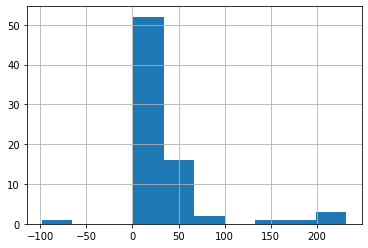

In [ ]:
df_sample_2['difference_1'].hist()

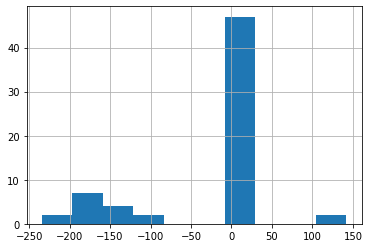

In [ ]:
df_sample_3['difference_2'].hist()

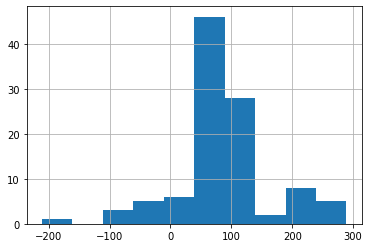

In [ ]:
df_sample_4['difference_3'].hist()

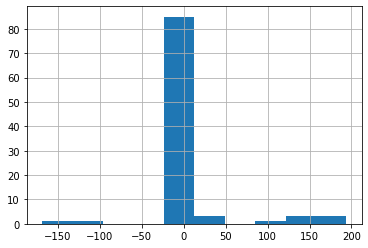

In [ ]:
df_sample_5['difference_4'].hist()

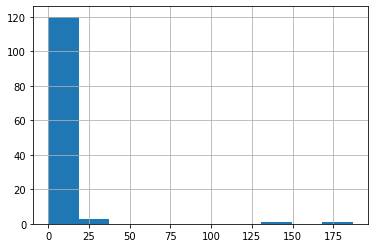

In [ ]:
df_sample_6['difference_5'].hist()

In [ ]:
# m1in ~ m1out 시간 차이 중에서 너무 큰 값은 이상치로 판단 -> 제거
for i, j in enumerate(df_dropped_resetIdx['MCIn1']):
    if (df_dropped_resetIdx.iloc[i, 6] - df_dropped_resetIdx.iloc[i, 4])>120 or (df_dropped_resetIdx.iloc[i, 6] - df_dropped_resetIdx.iloc[i, 4])<0:
        list_111 = ['MCIn2', 'MCOut2', 'MCIn3', 'MCOut3']
        list_121 = []
        list_122 = []
        for k in list_111:
            list_121.append(abs(df_dropped_resetIdx.iloc[i, 6]-df_dropped_resetIdx[k][i]))
            list_122.append(abs(df_dropped_resetIdx.iloc[i, 4]-df_dropped_resetIdx[k][i]))
        if sum(list_121) > sum(list_122):
            df_dropped_resetIdx.iloc[i, 6] = 0
        else :
            df_dropped_resetIdx.iloc[i, 4] = 0
        
# m1out ~ m2in 시간 차이 중에서 너무 큰 값은 이상치로 판단 -> 제거
for i, j in enumerate(df_dropped_resetIdx['MCIn1']):
    if (df_dropped_resetIdx.iloc[i, 7] - df_dropped_resetIdx.iloc[i, 6])>15 or (df_dropped_resetIdx.iloc[i, 7] - df_dropped_resetIdx.iloc[i, 6])<0:
        list_112 = ['MCIn1', 'MCOut2', 'MCIn3', 'MCOut3']
        list_123 = []
        list_124 = []
        for k in list_112:
            list_123.append(abs(df_dropped_resetIdx.iloc[i, 7]-df_dropped_resetIdx[k][i]))
            list_124.append(abs(df_dropped_resetIdx.iloc[i, 6]-df_dropped_resetIdx[k][i]))
        if sum(list_123) > sum(list_124):
            df_dropped_resetIdx.iloc[i, 7] = 0
        else :
            df_dropped_resetIdx.iloc[i, 6] = 0
        
# m2in ~ m2out 시간 차이 중에서 너무 큰 값은 이상치로 판단 -> 제거
for i, j in enumerate(df_dropped_resetIdx['MCIn1']):
    if (df_dropped_resetIdx.iloc[i, 9] - df_dropped_resetIdx.iloc[i, 7])>120 or (df_dropped_resetIdx.iloc[i, 9] - df_dropped_resetIdx.iloc[i, 7])<0:
        list_113 = ['MCIn1', 'MCOut1', 'MCIn3', 'MCOut3']
        list_125 = []
        list_126 = []
        for k in list_113:
            list_125.append(abs(df_dropped_resetIdx.iloc[i, 7]-df_dropped_resetIdx[k][i]))
            list_126.append(abs(df_dropped_resetIdx.iloc[i, 9]-df_dropped_resetIdx[k][i]))
        if sum(list_125) > sum(list_126):
            df_dropped_resetIdx.iloc[i, 7] = 0
        else :
            df_dropped_resetIdx.iloc[i, 9] = 0
        
# m2out ~ m3in 시간 차이 중에서 너무 큰 값은 이상치로 판단 -> 제거
for i, j in enumerate(df_dropped_resetIdx['MCIn1']):
    if (df_dropped_resetIdx.iloc[i, 10] - df_dropped_resetIdx.iloc[i, 9])>20 or (df_dropped_resetIdx.iloc[i, 10] - df_dropped_resetIdx.iloc[i, 9])<0:
        list_114 = ['MCIn1', 'MCOut1', 'MCIn2', 'MCOut3']
        list_127 = []
        list_128 = []
        for k in list_114:
            list_127.append(abs(df_dropped_resetIdx.iloc[i, 10]-df_dropped_resetIdx[k][i]))
            list_128.append(abs(df_dropped_resetIdx.iloc[i, 9]-df_dropped_resetIdx[k][i]))
        if sum(list_127) > sum(list_128):
            df_dropped_resetIdx.iloc[i, 10] = 0
        else :
            df_dropped_resetIdx.iloc[i, 9] = 0
        
# m3in ~ m3out 시간 차이 중에서 너무 큰 값은 이상치로 판단 -> 제거
for i, j in enumerate(df_dropped_resetIdx['MCIn1']):
    if (df_dropped_resetIdx.iloc[i, 12] - df_dropped_resetIdx.iloc[i, 10])>120 or (df_dropped_resetIdx.iloc[i, 12] - df_dropped_resetIdx.iloc[i, 10])<0:
        '''
        list_115 = ['MCIn1', 'MCOut1', 'MCIn2', 'MCOut2']
        list_129 = []
        list_130 = []
        
        for k in list_115:
            list_129.append(abs(df_dropped_resetIdx.iloc[i, 12]-df_dropped_resetIdx[k][i]))
            list_130.append(abs(df_dropped_resetIdx.iloc[i, 10]-df_dropped_resetIdx[k][i]))
        
        if sum(list_129) > sum(list_130):
            df_dropped_resetIdx.iloc[i, 12] = 0
        else :
            df_dropped_resetIdx.iloc[i, 10] = 0
        '''
        df_dropped_resetIdx.iloc[i, 10] = 0
        

In [ ]:
# mcout3열을 기준으로 오름차순 정렬
df_dropped_3=df_dropped_3.sort_values(by=['MCOut3'], axis=0, ascending=True)
df_dropped_3.head(16)
df_dropped_resetIdx= df_dropped_3

In [ ]:
# m1in & m1out 둘 다 찍힌 인덱스
df_idx_1 = df_dropped_resetIdx[(df_dropped_resetIdx['MCIn1'] != 0 ) & (df_dropped_resetIdx['MCOut1'] != 0 )].index
# m1out & m2in 둘 다 찍힌 인덱스
df_idx_2 = df_dropped_resetIdx[(df_dropped_resetIdx['MCOut1'] != 0 ) & (df_dropped_resetIdx['MCIn2'] != 0 )].index
# m2in & m2out 둘 다 찍힌 인덱스
df_idx_3 = df_dropped_resetIdx[(df_dropped_resetIdx['MCIn2'] != 0 ) & (df_dropped_resetIdx['MCOut2'] != 0 )].index
# m2out & m3in 둘 다 찍힌 인덱스
df_idx_4 = df_dropped_resetIdx[(df_dropped_resetIdx['MCOut2'] != 0 ) & (df_dropped_resetIdx['MCIn3'] != 0 )].index
# m3in & m3out 둘 다 찍힌 인덱스
df_idx_5 = df_dropped_resetIdx[(df_dropped_resetIdx['MCIn3'] != 0 ) & (df_dropped_resetIdx['MCOut3'] != 0 )].index

# 189 254 256 310 324
print(len(df_idx_1),len(df_idx_2),len(df_idx_3),len(df_idx_4),len(df_idx_5))

80 122 135 190 251


In [ ]:
# m1in ~ m1out 시간 차이 구하기
df_sample_2 = df_dropped_resetIdx.loc[df_idx_1]
df_sample_2['difference_1'] = df_sample_2['MCOut1'] - df_sample_2['MCIn1']
# m1out ~ m2in 시간 차이 구하기
df_sample_3 = df_dropped_resetIdx.loc[df_idx_2]
df_sample_3['difference_2'] = df_sample_3['MCIn2'] - df_sample_3['MCOut1']
# m2in ~ m2out 시간 차이 구하기
df_sample_4 = df_dropped_resetIdx.loc[df_idx_3]
df_sample_4['difference_3'] = df_sample_4['MCOut2'] - df_sample_4['MCIn2']
# m2out ~ m3in 시간 차이 구하기
df_sample_5 = df_dropped_resetIdx.loc[df_idx_4]
df_sample_5['difference_4'] = df_sample_5['MCIn3'] - df_sample_5['MCOut2']
# m3in ~ m3out 시간 차이 구하기
df_sample_6 = df_dropped_resetIdx.loc[df_idx_5]
df_sample_6['difference_5'] = df_sample_6['MCOut3'] - df_sample_6['MCIn3']

print(df_sample_2['difference_1'].mean(),'---', df_sample_3['difference_2'].mean(),'---', df_sample_4['difference_3'].mean()
     ,'---',df_sample_5['difference_4'].mean(),'---', df_sample_6['difference_5'].mean())

18.9375 --- 4.311475409836065 --- 51.577777777777776 --- 8.51578947368421 --- 29.254980079681275


In [ ]:
print(df_sample_2['difference_1'].describe(),'\n', df_sample_3['difference_2'].describe(),'\n'
     ,df_sample_4['difference_3'].describe(),'\n',df_sample_5['difference_4'].describe(),'\n'
     ,df_sample_6['difference_5'].describe())

count    80.000000
mean     18.937500
std      22.400465
min       1.000000
25%       4.000000
50%       9.500000
75%      27.000000
max      90.000000
Name: difference_1, dtype: float64 
 count    122.000000
mean       4.311475
std        2.616167
min        1.000000
25%        3.000000
50%        4.000000
75%        5.000000
max       15.000000
Name: difference_2, dtype: float64 
 count    135.000000
mean      51.577778
std       34.333628
min        4.000000
25%       22.000000
50%       42.000000
75%       81.500000
max      119.000000
Name: difference_3, dtype: float64 
 count    190.000000
mean       8.515789
std        3.300996
min        0.000000
25%        7.000000
50%        8.000000
75%       10.000000
max       20.000000
Name: difference_4, dtype: float64 
 count    251.000000
mean      29.254980
std       29.220108
min        0.000000
25%        7.000000
50%       17.000000
75%       42.000000
max      120.000000
Name: difference_5, dtype: float64


### MCOut3 누락값 채우기

In [ ]:
df_dropped_3 = df.copy()

In [ ]:
# MCOut3 열을 기준으로 오름차순 정렬
df_sort_mcout3=df_dropped_3.sort_values(by=['MCOut3'], axis=0, ascending=True)

# 인덱스 리셋
df_sort_mcout3 = df_sort_mcout3.reset_index(drop=True)
df_sort_mcout3

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
0,623,c37b877b,0,5,45789.00002,0.26,0.00000,0.00000,3.19,0.00000,45851.99996,11.52,0.00000
1,292,c37b7dfe,0,3,0.00000,0.39,0.00000,45641.00002,6.95,45665.00004,0.00000,4.22,0.00000
2,347,c37b770b,0,3,0.00000,2.41,0.00000,45721.00002,3.60,45748.00002,0.00000,2.68,0.00000
3,364,c37ba2e1,0,3,45612.00003,4.18,45644.99999,45647.99997,0.71,45675.99996,0.00000,2.71,0.00000
4,422,c37b9987,0,4,0.00000,1.84,0.00000,0.00000,5.40,0.00000,45888.99998,14.98,0.00000
5,443,c37b81a9,0,4,45790.00001,3.72,45678.00004,45681.00002,6.88,45706.00003,0.00000,3.80,0.00000
6,314,c37b83cb,0,3,45709.00001,4.58,45776.00002,45779.99999,2.89,45803.00002,0.00000,8.26,0.00000
7,546,c37b9e2f,0,5,45713.99998,3.68,45803.00002,0.00000,2.41,0.00000,0.00000,0.07,0.00000
8,494,c37b7a6e,0,4,45701.99997,9.13,45765.00000,45580.99997,1.26,45799.00004,0.00000,6.02,0.00000
9,595,c37b9aab,0,5,45700.99998,2.88,45742.99997,45746.00004,5.51,45795.99997,0.00000,2.58,0.00000


In [ ]:
df_new_1 = df_sort_mcout3.copy()
df_new_2 = df_sort_mcout3.copy()
df_new_1['diff'] = 0
df_new_1 = df_new_1.reset_index(drop=True)
df_new_1

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3,diff
0,623,c37b877b,0,5,45789.00002,0.26,0.00000,0.00000,3.19,0.00000,45851.99996,11.52,0.00000,0
1,292,c37b7dfe,0,3,0.00000,0.39,0.00000,45641.00002,6.95,45665.00004,0.00000,4.22,0.00000,0
2,347,c37b770b,0,3,0.00000,2.41,0.00000,45721.00002,3.60,45748.00002,0.00000,2.68,0.00000,0
3,364,c37ba2e1,0,3,45612.00003,4.18,45644.99999,45647.99997,0.71,45675.99996,0.00000,2.71,0.00000,0
4,422,c37b9987,0,4,0.00000,1.84,0.00000,0.00000,5.40,0.00000,45888.99998,14.98,0.00000,0
5,443,c37b81a9,0,4,45790.00001,3.72,45678.00004,45681.00002,6.88,45706.00003,0.00000,3.80,0.00000,0
6,314,c37b83cb,0,3,45709.00001,4.58,45776.00002,45779.99999,2.89,45803.00002,0.00000,8.26,0.00000,0
7,546,c37b9e2f,0,5,45713.99998,3.68,45803.00002,0.00000,2.41,0.00000,0.00000,0.07,0.00000,0
8,494,c37b7a6e,0,4,45701.99997,9.13,45765.00000,45580.99997,1.26,45799.00004,0.00000,6.02,0.00000,0
9,595,c37b9aab,0,5,45700.99998,2.88,45742.99997,45746.00004,5.51,45795.99997,0.00000,2.58,0.00000,0


In [ ]:
for i,j in enumerate(df_new_1['diff']):
    if i == len(df_new_1['diff'])-1:
        break
    df_new_1['diff'][i] = df_new_1['MCOut3'][i+1] - df_new_1['MCOut3'][i]

In [ ]:
df_new_1

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3,diff
0,623,c37b877b,0,5,45789.00002,0.26,0.00000,0.00000,3.19,0.00000,45851.99996,11.52,0.00000,0
1,292,c37b7dfe,0,3,0.00000,0.39,0.00000,45641.00002,6.95,45665.00004,0.00000,4.22,0.00000,0
2,347,c37b770b,0,3,0.00000,2.41,0.00000,45721.00002,3.60,45748.00002,0.00000,2.68,0.00000,0
3,364,c37ba2e1,0,3,45612.00003,4.18,45644.99999,45647.99997,0.71,45675.99996,0.00000,2.71,0.00000,0
4,422,c37b9987,0,4,0.00000,1.84,0.00000,0.00000,5.40,0.00000,45888.99998,14.98,0.00000,0
5,443,c37b81a9,0,4,45790.00001,3.72,45678.00004,45681.00002,6.88,45706.00003,0.00000,3.80,0.00000,0
6,314,c37b83cb,0,3,45709.00001,4.58,45776.00002,45779.99999,2.89,45803.00002,0.00000,8.26,0.00000,0
7,546,c37b9e2f,0,5,45713.99998,3.68,45803.00002,0.00000,2.41,0.00000,0.00000,0.07,0.00000,0
8,494,c37b7a6e,0,4,45701.99997,9.13,45765.00000,45580.99997,1.26,45799.00004,0.00000,6.02,0.00000,0
9,595,c37b9aab,0,5,45700.99998,2.88,45742.99997,45746.00004,5.51,45795.99997,0.00000,2.58,0.00000,39717


In [ ]:
#위에 몇개 자르기
df_new_1 = df_new_1.drop([0,1,2,3,4,5,6,7,8,9])
df_new_1 = df_new_1.reset_index(drop=True)
len(df_new_1['MCIn1'])

375

count    375.000000
mean      16.018667
std        7.380939
min        0.000000
25%       11.000000
50%       15.000000
75%       20.000000
max       50.000000
Name: diff, dtype: float64


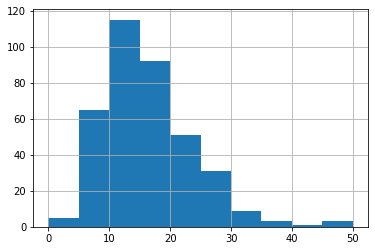

In [ ]:
print(df_new_1['diff'].describe())
df_new_1['diff'].hist()

count    375.000000
mean       3.805547
std        3.711658
min        0.010000
25%        1.080000
50%        2.610000
75%        5.495000
max       25.240000
Name: MC3Prtime, dtype: float64


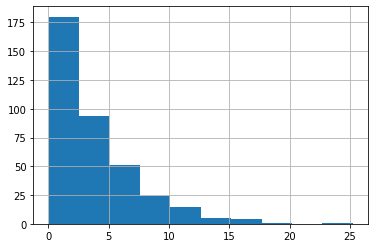

In [ ]:
print(df_new_1['MC3Prtime'].describe())
df_new_1['MC3Prtime'].hist()

In [ ]:
from random import *

#f = uniform(1.0, 36.5)   # 1부터 36.5 사이의 임의의 float
#print(f)
 

list_idx_1 = []
a = int(np.quantile(df_new_1['diff'], 0.75))
b = int(np.quantile(df_new_1['diff'], 0.5))

df_new_1['new'] = 0
list_append_1 = []

for i, j in enumerate(df_new_1['diff']):
    if j >= a:
        e = int(uniform(0.5, 1.5)*b)
        c = int(j / e)
        d = 1
        
        for k in range(1, c):
            list_append_1.append(df_new_1['MCOut3'][i] + d * e)
            d += 1

In [ ]:
len(list_append_1)

52

In [ ]:
list_append_1

[39753.0,
 39762.0,
 39830.00004,
 39918.99997,
 39999.99998,
 40229.00001,
 40243.00001,
 40268.99997,
 40484.99998,
 40493.99998,
 40539.99997,
 40575.00004,
 40606.99997,
 40784.00001,
 41116.0,
 41124.0,
 41585.00003,
 41594.00003,
 41621.00001,
 41707.99996,
 41848.0,
 41911.00003,
 41940.99999,
 41949.99999,
 42371.99999,
 42378.99999,
 42448.00003,
 42546.99997,
 42592.00002,
 42746.00003,
 42768.99997,
 43048.99998,
 43118.99996,
 43126.99996,
 43164.00002,
 43171.00002,
 43193.00001,
 43201.00001,
 43634.99997,
 43738.0,
 44198.0,
 44333.99998,
 44538.00003,
 44784.00003,
 44793.00003,
 45355.00001,
 45401.99997,
 45703.99997,
 45758.0,
 45765.0,
 45772.0,
 45790.0]

In [ ]:
for i,j in enumerate(list_append_1):
    df_new_2.loc[len(df_new_1['MCIn1']) + i] = [0,0,0,0,0,0,0,0,0,0,0,0, j]

In [ ]:
df_new_2 = df_new_2.reset_index(drop=True)
df_new_2=df_new_2.sort_values(by=['MCOut3'], axis=0, ascending=True)

df_new_2.head(300)

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
0,623.0,c37b877b,0.0,5.0,45789.00002,0.26,0.00000,0.00000,3.19,0.00000,45851.99996,11.52,0.00000
1,292.0,c37b7dfe,0.0,3.0,0.00000,0.39,0.00000,45641.00002,6.95,45665.00004,0.00000,4.22,0.00000
2,347.0,c37b770b,0.0,3.0,0.00000,2.41,0.00000,45721.00002,3.60,45748.00002,0.00000,2.68,0.00000
3,364.0,c37ba2e1,0.0,3.0,45612.00003,4.18,45644.99999,45647.99997,0.71,45675.99996,0.00000,2.71,0.00000
4,422.0,c37b9987,0.0,4.0,0.00000,1.84,0.00000,0.00000,5.40,0.00000,45888.99998,14.98,0.00000
5,443.0,c37b81a9,0.0,4.0,45790.00001,3.72,45678.00004,45681.00002,6.88,45706.00003,0.00000,3.80,0.00000
6,314.0,c37b83cb,0.0,3.0,45709.00001,4.58,45776.00002,45779.99999,2.89,45803.00002,0.00000,8.26,0.00000
7,546.0,c37b9e2f,0.0,5.0,45713.99998,3.68,45803.00002,0.00000,2.41,0.00000,0.00000,0.07,0.00000
8,494.0,c37b7a6e,0.0,4.0,45701.99997,9.13,45765.00000,45580.99997,1.26,45799.00004,0.00000,6.02,0.00000
9,595.0,c37b9aab,0.0,5.0,45700.99998,2.88,45742.99997,45746.00004,5.51,45795.99997,0.00000,2.58,0.00000


In [ ]:
df_new_2.tail(300)

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
111,7.0,c37ba1af,1.0,1.0,41431.00000,0.64,41495.00003,0.00000,1.17,0.00000,41517.99996,2.26,41525.00001
112,407.0,c37b9987,1.0,4.0,41292.00003,3.88,41485.00000,41488.99998,0.63,41504.99996,41391.00000,13.94,41544.99996
113,81.0,c37b7970,1.0,1.0,0.00000,0.14,0.00000,41508.00003,10.99,41523.00002,41415.00002,5.94,41556.99997
114,378.0,c37ba1b6,1.0,4.0,41392.99999,2.96,41437.99996,41304.00004,1.68,41481.00003,41566.00000,3.62,41576.00003
391,0.0,0,0.0,0.0,0.00000,0.00,0.00000,0.00000,0.00,0.00000,0.00000,0.00,41585.00003
392,0.0,0,0.0,0.0,0.00000,0.00,0.00000,0.00000,0.00,0.00000,0.00000,0.00,41594.00003
115,32.0,c37b81a6,1.0,1.0,0.00000,2.06,0.00000,41557.99997,27.25,41618.00002,41596.99998,4.02,41606.00001
393,0.0,0,0.0,0.0,0.00000,0.00,0.00000,0.00000,0.00,0.00000,0.00000,0.00,41621.00001
116,304.0,c37b83cb,1.0,3.0,41539.00000,0.43,41557.99997,41562.00003,0.84,41620.00000,41632.00001,0.90,41639.99996
117,353.0,c37ba2e1,1.0,3.0,41378.99999,5.45,41402.00002,41406.99998,4.88,41625.99996,41636.99998,2.05,41650.99998


In [ ]:
df_new_2['diff'] = 1
df_new_2 = df_new_2.reset_index(drop=True)
for i,j in enumerate(df_new_2['diff']):
    if i == len(df_new_2['diff'])-1:
        break
    df_new_2['diff'][i] = df_new_2['MCOut3'][i+1] - df_new_2['MCOut3'][i]

count      427.000000
mean       106.854801
std       1921.378269
min          0.000000
25%          9.000000
50%         13.000000
75%         18.000000
max      39717.000000
Name: diff, dtype: float64


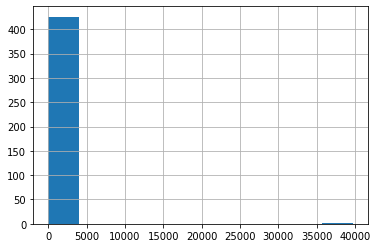

In [ ]:
print(df_new_2['diff'].describe())
df_new_2['diff'].hist()

In [ ]:
df_new_2['diff'][15] = 0
df_new_2['diff'][15]

0

In [ ]:
df_new_2.head(500)

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3,diff
0,623.0,c37b877b,0.0,5.0,45789.00002,0.26,0.00000,0.00000,3.19,0.00000,45851.99996,11.52,0.00000,0
1,292.0,c37b7dfe,0.0,3.0,0.00000,0.39,0.00000,45641.00002,6.95,45665.00004,0.00000,4.22,0.00000,0
2,347.0,c37b770b,0.0,3.0,0.00000,2.41,0.00000,45721.00002,3.60,45748.00002,0.00000,2.68,0.00000,0
3,364.0,c37ba2e1,0.0,3.0,45612.00003,4.18,45644.99999,45647.99997,0.71,45675.99996,0.00000,2.71,0.00000,0
4,422.0,c37b9987,0.0,4.0,0.00000,1.84,0.00000,0.00000,5.40,0.00000,45888.99998,14.98,0.00000,0
5,443.0,c37b81a9,0.0,4.0,45790.00001,3.72,45678.00004,45681.00002,6.88,45706.00003,0.00000,3.80,0.00000,0
6,314.0,c37b83cb,0.0,3.0,45709.00001,4.58,45776.00002,45779.99999,2.89,45803.00002,0.00000,8.26,0.00000,0
7,546.0,c37b9e2f,0.0,5.0,45713.99998,3.68,45803.00002,0.00000,2.41,0.00000,0.00000,0.07,0.00000,0
8,494.0,c37b7a6e,0.0,4.0,45701.99997,9.13,45765.00000,45580.99997,1.26,45799.00004,0.00000,6.02,0.00000,0
9,595.0,c37b9aab,0.0,5.0,45700.99998,2.88,45742.99997,45746.00004,5.51,45795.99997,0.00000,2.58,0.00000,39717


In [ ]:
df_new_2.tail(300)

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3,diff
127,7.0,c37ba1af,1.0,1.0,41431.00000,0.64,41495.00003,0.00000,1.17,0.00000,41517.99996,2.26,41525.00001,19
128,407.0,c37b9987,1.0,4.0,41292.00003,3.88,41485.00000,41488.99998,0.63,41504.99996,41391.00000,13.94,41544.99996,12
129,81.0,c37b7970,1.0,1.0,0.00000,0.14,0.00000,41508.00003,10.99,41523.00002,41415.00002,5.94,41556.99997,19
130,378.0,c37ba1b6,1.0,4.0,41392.99999,2.96,41437.99996,41304.00004,1.68,41481.00003,41566.00000,3.62,41576.00003,9
131,0.0,0,0.0,0.0,0.00000,0.00,0.00000,0.00000,0.00,0.00000,0.00000,0.00,41585.00003,9
132,0.0,0,0.0,0.0,0.00000,0.00,0.00000,0.00000,0.00,0.00000,0.00000,0.00,41594.00003,11
133,32.0,c37b81a6,1.0,1.0,0.00000,2.06,0.00000,41557.99997,27.25,41618.00002,41596.99998,4.02,41606.00001,15
134,0.0,0,0.0,0.0,0.00000,0.00,0.00000,0.00000,0.00,0.00000,0.00000,0.00,41621.00001,18
135,304.0,c37b83cb,1.0,3.0,41539.00000,0.43,41557.99997,41562.00003,0.84,41620.00000,41632.00001,0.90,41639.99996,11
136,353.0,c37ba2e1,1.0,3.0,41378.99999,5.45,41402.00002,41406.99998,4.88,41625.99996,41636.99998,2.05,41650.99998,14


In [ ]:
df_dropped_3=df_new_2.drop(['diff'], axis=1).copy()
df_dropped_3

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
0,623.0,c37b877b,0.0,5.0,45789.00002,0.26,0.00000,0.00000,3.19,0.00000,45851.99996,11.52,0.00000
1,292.0,c37b7dfe,0.0,3.0,0.00000,0.39,0.00000,45641.00002,6.95,45665.00004,0.00000,4.22,0.00000
2,347.0,c37b770b,0.0,3.0,0.00000,2.41,0.00000,45721.00002,3.60,45748.00002,0.00000,2.68,0.00000
3,364.0,c37ba2e1,0.0,3.0,45612.00003,4.18,45644.99999,45647.99997,0.71,45675.99996,0.00000,2.71,0.00000
4,422.0,c37b9987,0.0,4.0,0.00000,1.84,0.00000,0.00000,5.40,0.00000,45888.99998,14.98,0.00000
5,443.0,c37b81a9,0.0,4.0,45790.00001,3.72,45678.00004,45681.00002,6.88,45706.00003,0.00000,3.80,0.00000
6,314.0,c37b83cb,0.0,3.0,45709.00001,4.58,45776.00002,45779.99999,2.89,45803.00002,0.00000,8.26,0.00000
7,546.0,c37b9e2f,0.0,5.0,45713.99998,3.68,45803.00002,0.00000,2.41,0.00000,0.00000,0.07,0.00000
8,494.0,c37b7a6e,0.0,4.0,45701.99997,9.13,45765.00000,45580.99997,1.26,45799.00004,0.00000,6.02,0.00000
9,595.0,c37b9aab,0.0,5.0,45700.99998,2.88,45742.99997,45746.00004,5.51,45795.99997,0.00000,2.58,0.00000


### MCPrtime 결측치 채우기

In [ ]:
for i,j in enumerate(df_dropped_3['MC3Prtime']):
    if j == 0:
        df_dropped_3['MC3Prtime'][i] = np.random.exponential(1/0.25)
        
for i,j in enumerate(df_dropped_3['MC2Prtime']):
    if j == 0:
        df_dropped_3['MC2Prtime'][i] = np.random.exponential(1/0.25)
        
for i,j in enumerate(df_dropped_3['MC1Prtime']):
    if j == 0:
        df_dropped_3['MC1Prtime'][i] = np.random.exponential(1/0.25)

In [ ]:
df_dropped_3.head(500)

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
0,623.0,c37b877b,0.0,5.0,45789.00002,0.260000,0.00000,0.00000,3.190000,0.00000,45851.99996,11.520000,0.00000
1,292.0,c37b7dfe,0.0,3.0,0.00000,0.390000,0.00000,45641.00002,6.950000,45665.00004,0.00000,4.220000,0.00000
2,347.0,c37b770b,0.0,3.0,0.00000,2.410000,0.00000,45721.00002,3.600000,45748.00002,0.00000,2.680000,0.00000
3,364.0,c37ba2e1,0.0,3.0,45612.00003,4.180000,45644.99999,45647.99997,0.710000,45675.99996,0.00000,2.710000,0.00000
4,422.0,c37b9987,0.0,4.0,0.00000,1.840000,0.00000,0.00000,5.400000,0.00000,45888.99998,14.980000,0.00000
5,443.0,c37b81a9,0.0,4.0,45790.00001,3.720000,45678.00004,45681.00002,6.880000,45706.00003,0.00000,3.800000,0.00000
6,314.0,c37b83cb,0.0,3.0,45709.00001,4.580000,45776.00002,45779.99999,2.890000,45803.00002,0.00000,8.260000,0.00000
7,546.0,c37b9e2f,0.0,5.0,45713.99998,3.680000,45803.00002,0.00000,2.410000,0.00000,0.00000,0.070000,0.00000
8,494.0,c37b7a6e,0.0,4.0,45701.99997,9.130000,45765.00000,45580.99997,1.260000,45799.00004,0.00000,6.020000,0.00000
9,595.0,c37b9aab,0.0,5.0,45700.99998,2.880000,45742.99997,45746.00004,5.510000,45795.99997,0.00000,2.580000,0.00000


### MCOut3 결측치 채우기

In [ ]:
#열별로 결측값 개수 확인
count1=0

for i in df_dropped_3:
    count2 = 0
    for j in df_dropped_3[i]:
        if j == 0:
            count2+=1
    print('-'*50)
    print(i,"열의 결측값 개수:",count2)
    count1+=count2
    
print('-'*50)
print('전체 결측치:',count1)

--------------------------------------------------
id 열의 결측값 개수: 256
--------------------------------------------------
Uid 열의 결측값 개수: 256
--------------------------------------------------
completed 열의 결측값 개수: 272
--------------------------------------------------
CycleNumber 열의 결측값 개수: 256
--------------------------------------------------
MCIn1 열의 결측값 개수: 395
--------------------------------------------------
MC1Prtime 열의 결측값 개수: 0
--------------------------------------------------
MCOut1 열의 결측값 개수: 277
--------------------------------------------------
MCIn2 열의 결측값 개수: 327
--------------------------------------------------
MC2Prtime 열의 결측값 개수: 0
--------------------------------------------------
MCOut2 열의 결측값 개수: 271
--------------------------------------------------
MCIn3 열의 결측값 개수: 272
--------------------------------------------------
MC3Prtime 열의 결측값 개수: 0
--------------------------------------------------
MCOut3 열의 결측값 개수: 16
--------------------------------------------------


In [ ]:
# MCOut3 열을 기준으로 오름차순 정렬
df_sort_mcout3=df_dropped_3.sort_values(by=['MCOut3'], axis=0, ascending=True)

# 인덱스 리셋
df_sort_mcout3 = df_sort_mcout3.reset_index(drop=True)
df_sort_mcout3

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
0,488,c37b7a6e,0.0,4.0,0,0.150000,45160,45162,3.400000,0,0,3.190000,0
1,540,c37b9e2f,0.0,5.0,45116,0.810000,0,45119,5.870000,45173,0,2.890000,0
2,517,c37b82d7,0.0,5.0,45186,6.640000,45230,0,2.430000,45232,0,23.230000,0
3,45,c37b81a6,0.0,1.0,45262,2.480000,45267,45094,2.240000,45275,0,4.100000,0
4,448,c37b81a9,0.0,4.0,0,2.540000,45273,45277,9.760000,45288,0,0.460000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
575,0,0,0.0,0.0,0,4.059281,0,0,0.051308,0,0,0.330085,45381
576,0,0,0.0,0.0,0,5.672093,0,0,6.904487,0,0,2.695824,45390
577,0,0,0.0,0.0,0,15.819619,0,0,1.224987,0,0,3.537807,45399
578,566,c37b84f4,1.0,5.0,44791,2.360000,45239,45243,2.400000,45253,45283,4.020000,45414


In [ ]:
#mcout3 순서확인
check_col_order(df_sort_mcout3, 'MCOut3')

----------------------------------------------------------------------
열 내 순서 확인 시작
마지막 행( 579 )은 비교불가
이상값: 0
열 내 순서 확인 완료
----------------------------------------------------------------------


In [ ]:
#prtime 확인
check_outPrtime(df_sort_mcout3, 'MC3Prtime', 'MCOut3')
check_outPrtime_sum(df_sort_mcout3, 'MC3Prtime', 'MCOut3')

----------------------------------------------------------------------
MCOut + MCPrtime 확인 시작
----------------------------------------------------------------------
0 번째 행 확인바람
MC3Prtime + MCOut3 : 3.19 다음행 MCOut3 : 0
----------------------------------------------------------------------
1 번째 행 확인바람
MC3Prtime + MCOut3 : 2.89 다음행 MCOut3 : 0
----------------------------------------------------------------------
2 번째 행 확인바람
MC3Prtime + MCOut3 : 23.23 다음행 MCOut3 : 0
----------------------------------------------------------------------
3 번째 행 확인바람
MC3Prtime + MCOut3 : 4.1 다음행 MCOut3 : 0
----------------------------------------------------------------------
4 번째 행 확인바람
MC3Prtime + MCOut3 : 0.46 다음행 MCOut3 : 0
----------------------------------------------------------------------
5 번째 행 확인바람
MC3Prtime + MCOut3 : 5.53 다음행 MCOut3 : 0
----------------------------------------------------------------------
6 번째 행 확인바람
MC3Prtime + MCOut3 : 5.67 다음행 MCOut3 : 0
--------------------------------------

In [ ]:
check_col_order(df_sort_mcout3, 'MCOut3')

----------------------------------------------------------------------
열 내 순서 확인 시작
마지막 행( 579 )은 비교불가
이상값: 0
열 내 순서 확인 완료
----------------------------------------------------------------------


In [ ]:
df_sort_mcout3.head(20)

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
0,488,c37b7a6e,0.0,4.0,0,0.15,45160,45162,3.40,0,0,3.19,0
1,540,c37b9e2f,0.0,5.0,45116,0.81,0,45119,5.87,45173,0,2.89,4
2,517,c37b82d7,0.0,5.0,45186,6.64,45230,0,2.43,45232,0,23.23,7
3,45,c37b81a6,0.0,1.0,45262,2.48,45267,45094,2.24,45275,0,4.10,31
4,448,c37b81a9,0.0,4.0,0,2.54,45273,45277,9.76,45288,0,0.46,36
5,419,c37b9987,0.0,4.0,45159,0.61,45171,45178,3.66,45217,0,5.53,37
6,364,c37ba2e1,0.0,3.0,45046,1.56,45235,44897,2.23,45251,0,5.67,43
7,595,c37b9aab,0.0,5.0,45212,0.18,45232,45238,1.95,45243,0,2.84,49
8,392,c37ba1b6,0.0,4.0,0,0.91,43608,43440,9.10,43682,0,1.98,52
9,335,c37b770b,0.0,3.0,45121,0.52,0,45132,0.28,45179,0,8.07,54


In [ ]:
#불완전 데이터 삭제
df_sort_mcout3 = df_sort_mcout3.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
df_sort_mcout3 = df_sort_mcout3.reset_index(drop=True)
df_sort_mcout3

#check_col_order(df_sort_mcout3, 'MCOut3')
#check_outPrtime(df_sort_mcout3, 'MC3Prtime', 'MCOut3')

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
0,276,c37b7dfe,1.0,3.0,35958,6.120000,35972,0,2.400000,35977,35986,0.560000,35988
1,551,c37b84f4,1.0,5.0,0,8.120000,35982,0,0.700000,35989,35998,5.460000,36005
2,526,c37b9e2f,1.0,5.0,0,2.010000,35987,35991,7.750000,36010,36012,7.320000,36018
3,301,c37b83cb,1.0,3.0,0,4.880000,0,0,2.130000,36015,36022,2.100000,36028
4,401,c37b9987,1.0,4.0,0,6.410000,35998,36000,0.670000,36018,36029,0.610000,36045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,0,0,0.0,0.0,0,4.059281,0,0,0.051308,0,0,0.330085,45381
560,0,0,0.0,0.0,0,5.672093,0,0,6.904487,0,0,2.695824,45390
561,0,0,0.0,0.0,0,15.819619,0,0,1.224987,0,0,3.537807,45399
562,566,c37b84f4,1.0,5.0,44791,2.360000,45239,45243,2.400000,45253,45283,4.020000,45414


In [ ]:
# MCIn3 열 내 순서 확인
check_col_order(df_sort_mcout3, 'MCIn3')

----------------------------------------------------------------------
열 내 순서 확인 시작
인덱스: 30
인덱스: 38
인덱스: 39
인덱스: 79
인덱스: 115
인덱스: 141
인덱스: 172
인덱스: 173
인덱스: 246
인덱스: 264
인덱스: 287
인덱스: 330
인덱스: 401
인덱스: 491
인덱스: 496
인덱스: 500
인덱스: 503
인덱스: 504
인덱스: 562
마지막 행( 563 )은 비교불가
이상값: 19
열 내 순서 확인 완료
----------------------------------------------------------------------


In [ ]:
# MCIn3 열 내 순서 맞지 않는 값 제거
check_col_order_del(df_sort_mcout3, 'MCIn3')

----------------------------------------------------------------------
제거 시작
인덱스- 30 제거
인덱스- 38 제거
인덱스- 39 제거
인덱스- 79 제거
인덱스- 115 제거
인덱스- 141 제거
인덱스- 172 제거
인덱스- 173 제거
인덱스- 246 제거
인덱스- 264 제거
인덱스- 287 제거
인덱스- 330 제거
인덱스- 401 제거
인덱스- 491 제거
인덱스- 496 제거
인덱스- 500 제거
인덱스- 503 제거
인덱스- 504 제거
인덱스- 562 제거
마지막 행( 563 )은 비교불가
제거 완료
----------------------------------------------------------------------


In [ ]:
check_col_order(df_sort_mcout3, 'MCIn3')

----------------------------------------------------------------------
열 내 순서 확인 시작
마지막 행( 563 )은 비교불가
이상값: 0
열 내 순서 확인 완료
----------------------------------------------------------------------


In [ ]:
# MCOut2 + MC2Prtime < MCIn3 이 아닌 값 확인
check_outPrtimeIn(df_sort_mcout3, 'MCOut2', 'MC2Prtime', 'MCIn3')

----------------------------------------------------------------------
확인 시작
----------------------------------------------------------------------
2 번째 행 확인바람
MCOut+MCPrTime: 36017.75 MCIn: 36012
----------------------------------------------------------------------
9 번째 행 확인바람
MCOut+MCPrTime: 0.08247017980883087 MCIn: 0
----------------------------------------------------------------------
10 번째 행 확인바람
MCOut+MCPrTime: 5.653271267434486 MCIn: 0
----------------------------------------------------------------------
11 번째 행 확인바람
MCOut+MCPrTime: 0.9278952575987703 MCIn: 0
----------------------------------------------------------------------
12 번째 행 확인바람
MCOut+MCPrTime: 0.9150487506742846 MCIn: 0
----------------------------------------------------------------------
13 번째 행 확인바람
MCOut+MCPrTime: 2.905655167091806 MCIn: 0
----------------------------------------------------------------------
14 번째 행 확인바람
MCOut+MCPrTime: 0.20878691009543265 MCIn: 0
------------------------------------------

In [ ]:
df_sort_mcout3

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
0,276,c37b7dfe,1.0,3.0,35958,6.120000,35972,0,2.400000,35977,35986,0.560000,35988
1,551,c37b84f4,1.0,5.0,0,8.120000,35982,0,0.700000,35989,35998,5.460000,36005
2,526,c37b9e2f,1.0,5.0,0,2.010000,35987,35991,7.750000,36010,36012,7.320000,36018
3,301,c37b83cb,1.0,3.0,0,4.880000,0,0,2.130000,36015,36022,2.100000,36028
4,401,c37b9987,1.0,4.0,0,6.410000,35998,36000,0.670000,36018,36029,0.610000,36045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,0,0,0.0,0.0,0,4.059281,0,0,0.051308,0,0,0.330085,45381
560,0,0,0.0,0.0,0,5.672093,0,0,6.904487,0,0,2.695824,45390
561,0,0,0.0,0.0,0,15.819619,0,0,1.224987,0,0,3.537807,45399
562,566,c37b84f4,1.0,5.0,44791,2.360000,45239,45243,2.400000,45253,0,4.020000,45414


In [ ]:
#마지막 데이터 삭제(conwip, 15)
#df_sort_mcout3 = df_sort_mcout3.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14])
#df_sort_mcout3 = df_sort_mcout3.reset_index(drop=True)
#df_sort_mcout3

#check_col_order(df_sort_mcout3, 'MCOut3')
#check_outPrtime(df_sort_mcout3, 'MC3Prtime', 'MCOut3')
df_sort_mcout3

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
0,276,c37b7dfe,1.0,3.0,35958,6.120000,35972,0,2.400000,35977,35986,0.560000,35988
1,551,c37b84f4,1.0,5.0,0,8.120000,35982,0,0.700000,35989,35998,5.460000,36005
2,526,c37b9e2f,1.0,5.0,0,2.010000,35987,35991,7.750000,36010,36012,7.320000,36018
3,301,c37b83cb,1.0,3.0,0,4.880000,0,0,2.130000,36015,36022,2.100000,36028
4,401,c37b9987,1.0,4.0,0,6.410000,35998,36000,0.670000,36018,36029,0.610000,36045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,0,0,0.0,0.0,0,4.059281,0,0,0.051308,0,0,0.330085,45381
560,0,0,0.0,0.0,0,5.672093,0,0,6.904487,0,0,2.695824,45390
561,0,0,0.0,0.0,0,15.819619,0,0,1.224987,0,0,3.537807,45399
562,566,c37b84f4,1.0,5.0,44791,2.360000,45239,45243,2.400000,45253,0,4.020000,45414


In [ ]:
# MCOut2 + MC2Prtime < MCIn3 이 아닌 값 제거
check_outPrtimeIn_del(df_sort_mcout3, 'MCOut2', 'MC2Prtime', 'MCIn3')

----------------------------------------------------------------------
제거 시작
제거 완료
----------------------------------------------------------------------


In [ ]:
#열별로 결측값 개수 확인
count1=0

for i in df_sort_mcout3:
    count2 = 0
    for j in df_sort_mcout3[i]:
        if j == 0:
            count2+=1
    print('-'*50)
    print(i,"열의 결측값 개수:",count2)
    count1+=count2
    
print('-'*50)
print('전체 결측치:',count1)

--------------------------------------------------
id 열의 결측값 개수: 256
--------------------------------------------------
Uid 열의 결측값 개수: 256
--------------------------------------------------
completed 열의 결측값 개수: 256
--------------------------------------------------
CycleNumber 열의 결측값 개수: 256
--------------------------------------------------
MCIn1 열의 결측값 개수: 392
--------------------------------------------------
MC1Prtime 열의 결측값 개수: 0
--------------------------------------------------
MCOut1 열의 결측값 개수: 275
--------------------------------------------------
MCIn2 열의 결측값 개수: 325
--------------------------------------------------
MC2Prtime 열의 결측값 개수: 0
--------------------------------------------------
MCOut2 열의 결측값 개수: 330
--------------------------------------------------
MCIn3 열의 결측값 개수: 275
--------------------------------------------------
MC3Prtime 열의 결측값 개수: 0
--------------------------------------------------
MCOut3 열의 결측값 개수: 0
--------------------------------------------------
전

In [ ]:
df_sort_mcout3.head(100)

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
0,276,c37b7dfe,1.0,3.0,35958,6.120000,35972,0,2.400000,35977,35986,0.560000,35988
1,551,c37b84f4,1.0,5.0,0,8.120000,35982,0,0.700000,35989,35998,5.460000,36005
2,526,c37b9e2f,1.0,5.0,0,2.010000,35987,35991,7.750000,0,36012,7.320000,36018
3,301,c37b83cb,1.0,3.0,0,4.880000,0,0,2.130000,0,0,2.100000,36028
4,401,c37b9987,1.0,4.0,0,6.410000,35998,36000,0.670000,36018,36029,0.610000,36045
5,326,c37b770b,1.0,3.0,0,1.260000,36029,36032,2.780000,36039,36048,1.050000,36079
6,351,c37ba2e1,1.0,3.0,0,0.470000,0,0,3.850000,0,36084,14.280000,36113
7,376,c37ba1b6,1.0,4.0,0,4.220000,0,0,2.630000,36095,36099,4.760000,36130
8,1,c37ba1af,1.0,1.0,36037,2.740000,36085,0,1.900000,0,36120,0.140000,36138
9,0,0,0.0,0.0,0,5.943807,0,0,0.659776,0,0,20.350170,36150


### CONWIP확인

In [ ]:
count=0
for i,j in enumerate(df_sort_mcout3['MCIn1']):
    if i == len(df_sort_mcout3['MCIn1']) - conwip:
        break
    
    if (df_sort_mcout3['MCIn1'][i+conwip] != 0):
        if (df_sort_mcout3['MCOut3'][i] + df_sort_mcout3['MC3Prtime'][i] + 2) > (df_sort_mcout3['MCIn1'][i+conwip]):
            count +=1
            print(i,'행 m3out과',i+20,'행m1in 확인 바람')
            print(count,'개 (count)')
            print('-'*20)
        
    

43 행 m3out과 63 행m1in 확인 바람
1 개 (count)
--------------------
106 행 m3out과 126 행m1in 확인 바람
2 개 (count)
--------------------
129 행 m3out과 149 행m1in 확인 바람
3 개 (count)
--------------------
144 행 m3out과 164 행m1in 확인 바람
4 개 (count)
--------------------
157 행 m3out과 177 행m1in 확인 바람
5 개 (count)
--------------------
164 행 m3out과 184 행m1in 확인 바람
6 개 (count)
--------------------
173 행 m3out과 193 행m1in 확인 바람
7 개 (count)
--------------------
194 행 m3out과 214 행m1in 확인 바람
8 개 (count)
--------------------
198 행 m3out과 218 행m1in 확인 바람
9 개 (count)
--------------------
200 행 m3out과 220 행m1in 확인 바람
10 개 (count)
--------------------
208 행 m3out과 228 행m1in 확인 바람
11 개 (count)
--------------------
209 행 m3out과 229 행m1in 확인 바람
12 개 (count)
--------------------
214 행 m3out과 234 행m1in 확인 바람
13 개 (count)
--------------------
215 행 m3out과 235 행m1in 확인 바람
14 개 (count)
--------------------
220 행 m3out과 240 행m1in 확인 바람
15 개 (count)
--------------------
227 행 m3out과 247 행m1in 확인 바람
16 개 (count)
--------------------
235

### MCIn3~ MCIn1 결측치 채우기

In [ ]:
#통합
t=20
while t != 0:
    add_median_first(df_sort_mcout3, 'MCIn1',0.5)
    check_col_order(df_sort_mcout3,'MCIn1')
    check_col_order_del_updown(df_sort_mcout3,'MCIn1')
    check_conwip(df_sort_mcout3)

    add_median_first(df_sort_mcout3, 'MCIn3',0.5)
    check_col_order(df_sort_mcout3,'MCIn3')
    check_col_order_del_updown(df_sort_mcout3,'MCIn3')    

    add_median_first(df_sort_mcout3, 'MCOut1',0.5)
    check_col_order(df_sort_mcout3,'MCOut1')
    check_col_order_del_updown(df_sort_mcout3,'MCOut1')

    add_median_first(df_sort_mcout3, 'MCOut2', 0.5)
    check_col_order(df_sort_mcout3,'MCOut2')
    check_col_order_del_updown(df_sort_mcout3,'MCOut2')

    add_median_first(df_sort_mcout3, 'MCIn2', 0.5)
    check_col_order(df_sort_mcout3,'MCIn2')
    check_col_order_del_updown(df_sort_mcout3,'MCIn2')

    t -= 1

----------------------------------------------------------------------
열 내 순서 확인 시작
인덱스: 19
인덱스: 20
인덱스: 21
인덱스: 24
인덱스: 26
인덱스: 28
인덱스: 114
인덱스: 154
인덱스: 199
인덱스: 295
인덱스: 302
인덱스: 331
인덱스: 333
인덱스: 336
인덱스: 346
마지막 행( 384 )은 비교불가
이상값: 15
열 내 순서 확인 완료
----------------------------------------------------------------------
----------------------------------------------------------------------
제거 시작
인덱스- 18 19 20 제거
인덱스- 20 21 22 제거
인덱스- 23 24 25 제거
인덱스- 25 26 27 제거
인덱스- 27 28 29 제거
인덱스- 113 114 115 제거
인덱스- 153 154 155 제거
인덱스- 198 199 200 제거
인덱스- 294 295 296 제거
인덱스- 301 302 303 제거
인덱스- 330 331 332 제거
인덱스- 332 333 334 제거
인덱스- 335 336 337 제거
인덱스- 345 346 347 제거
마지막 행( 384 )은 비교불가
제거 완료
----------------------------------------------------------------------
----------------------------------------------------------------------
열 내 순서 확인 시작
마지막 행( 384 )은 비교불가
이상값: 0
열 내 순서 확인 완료
----------------------------------------------------------------------
--------------------------------------------

In [ ]:
#열별로 결측값 개수 확인
count1=0

for i in df_sort_mcout3:
    count2 = 0
    for j in df_sort_mcout3[i]:
        if j == 0:
            count2+=1
    print('-'*50)
    print(i,"열의 결측값 개수:",count2)
    count1+=count2
    
print('-'*50)
print('전체 결측치:',count1)

--------------------------------------------------
id 열의 결측값 개수: 0
--------------------------------------------------
Uid 열의 결측값 개수: 0
--------------------------------------------------
completed 열의 결측값 개수: 10
--------------------------------------------------
CycleNumber 열의 결측값 개수: 0
--------------------------------------------------
MCIn1 열의 결측값 개수: 7
--------------------------------------------------
MC1Prtime 열의 결측값 개수: 0
--------------------------------------------------
MCOut1 열의 결측값 개수: 5
--------------------------------------------------
MCIn2 열의 결측값 개수: 5
--------------------------------------------------
MC2Prtime 열의 결측값 개수: 0
--------------------------------------------------
MCOut2 열의 결측값 개수: 6
--------------------------------------------------
MCIn3 열의 결측값 개수: 8
--------------------------------------------------
MC3Prtime 열의 결측값 개수: 0
--------------------------------------------------
MCOut3 열의 결측값 개수: 10
--------------------------------------------------
전체 결측치: 51


In [ ]:
# #MCIn1
# t=10
# while t != 0:
#     add_median_first(df_sort_mcout3, 'MCIn1',0.5)
#     check_col_order(df_sort_mcout3,'MCIn1')
#     check_col_order_del(df_sort_mcout3,'MCIn1')
#     check_conwip(df_sort_mcout3)
#     t -= 1

t=10
while t != 0:
    check_col_order(df_sort_mcout3,'MCIn1')
    check_col_order_del_updown2(df_sort_mcout3,'MCIn1')
    check_minmax_ran(df_sort_mcout3, 'MCIn1', [], ['MCOut1','MCIn2','MCOut2','MCIn3','MCOut3'])
    check_conwip(df_sort_mcout3)
    t -= 1



# #MCIn3
# t=10
# while t != 0:
#     add_median_first(df_sort_mcout3, 'MCIn3',0.5)
#     check_col_order(df_sort_mcout3,'MCIn3')
#     check_col_order_del2(df_sort_mcout3,'MCIn3')
#     t -= 1

t=10
while t != 0:
    check_minmax_ran(df_sort_mcout3, 'MCIn3', ['MCIn1','MCOut1','MCIn2','MCOut2'], ['MCOut3'])
    check_col_order(df_sort_mcout3,'MCIn3')
    check_col_order_del_updown2(df_sort_mcout3,'MCIn3')
    t -= 1



# #MCOut1
# t=10
# while t != 0:
#     add_median_first(df_sort_mcout3, 'MCOut1',0.5)
#     check_col_order(df_sort_mcout3,'MCOut1')
#     check_col_order_del(df_sort_mcout3,'MCOut1')
#     t -= 1

t=10
while t != 0:
    check_minmax_ran(df_sort_mcout3, 'MCOut1', ['MCIn1'], ['MCIn2','MCOut2','MCIn3','MCOut3'])
    check_col_order(df_sort_mcout3,'MCOut1')
    check_col_order_del_updown2(df_sort_mcout3,'MCOut1')
    t -= 1



# #MCOut2
# t=10
# while t != 0:
#     add_median_first(df_sort_mcout3, 'MCOut2', 0.5)
#     check_col_order(df_sort_mcout3,'MCOut2')
#     check_col_order_del(df_sort_mcout3,'MCOut2')
#     t -= 1

t=10
while t != 0:
    check_minmax_ran(df_sort_mcout3, 'MCOut2', ['MCIn1','MCOut1','MCIn2'], ['MCIn3','MCOut3'])
    check_col_order(df_sort_mcout3,'MCOut2')
    check_col_order_del_updown2(df_sort_mcout3,'MCOut2')
    t -= 1



# #MCIn2
# t = 10
# while t != 0:
#     add_median_first(df_sort_mcout3, 'MCIn2', 0.5)
#     check_col_order(df_sort_mcout3,'MCIn2')
#     check_col_order_del(df_sort_mcout3,'MCIn2')
#     t -= 1

t = 10
while t != 0:
    check_minmax_ran(df_sort_mcout3, 'MCIn2', ['MCIn1','MCOut1'], ['MCOut2','MCIn3','MCOut3'])
    check_col_order(df_sort_mcout3,'MCIn2')
    check_col_order_del_updown2(df_sort_mcout3,'MCIn2')
    t -= 1

#열별로 결측값 개수 확인
count1=0

for i in df_sort_mcout3:
    count2 = 0
    for j in df_sort_mcout3[i]:
        if j == 0:
            count2+=1
    print('-'*50)
    print(i,"열의 결측값 개수:",count2)
    count1+=count2
    
print('-'*50)
print('전체 결측치:',count1)

----------------------------------------------------------------------
열 내 순서 확인 시작
마지막 행( 563 )은 비교불가
이상값: 0
열 내 순서 확인 완료
----------------------------------------------------------------------
----------------------------------------------------------------------
제거 시작
마지막 행( 563 )은 비교불가
제거 완료
----------------------------------------------------------------------
--------------------------------------------------
18 행 입니다.
up: 36187
left: 36187
right: 36208
down: 35991
해당 행은 무시( 1 )
--------------------------------------------------
19 행 입니다.
up: 36187
left: 36187
right: 36226
down: 35991
해당 행은 무시( 2 )
----------------------------------------------------------------------
열 내 순서 확인 시작
인덱스: 17
인덱스: 19
마지막 행( 563 )은 비교불가
이상값: 2
열 내 순서 확인 완료
----------------------------------------------------------------------
----------------------------------------------------------------------
제거 시작
인덱스- 16 17 18 제거
마지막 행( 563 )은 비교불가
제거 완료
------------------------------------------------------------

In [ ]:
df_dropped_resetIdx = df_sort_mcout3
df_dropped_resetIdx

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
0,623,c37b877b,0,5,45741.99996,0.26,45764.49996,45767.49996,3.19,45843.99996,45851.99996,11.52,0.00000
1,292,c37b7dfe,0,3,0.00000,0.39,0.00000,0.00000,6.95,0.00000,0.00000,4.22,0.00000
2,347,c37b770b,0,3,0.00000,2.41,0.00000,0.00000,3.60,0.00000,0.00000,2.68,0.00000
3,364,c37ba2e1,0,3,45612.00003,4.18,45644.99999,45647.99997,0.71,45675.99996,0.00000,2.71,0.00000
4,422,c37b9987,0,4,45778.99998,1.84,45801.49998,45804.49998,5.40,45880.99998,45888.99998,14.98,0.00000
5,443,c37b81a9,0,4,0.00000,3.72,0.00000,0.00000,6.88,0.00000,0.00000,3.80,0.00000
6,314,c37b83cb,0,3,45709.00001,4.58,45776.00002,45779.99999,2.89,45803.00002,0.00000,8.26,0.00000
7,546,c37b9e2f,0,5,0.00000,3.68,0.00000,0.00000,2.41,0.00000,0.00000,0.07,0.00000
8,494,c37b7a6e,0,4,45555.49997,9.13,45577.99997,45580.99997,1.26,0.00000,0.00000,6.02,0.00000
9,595,c37b9aab,0,5,0.00000,2.88,0.00000,0.00000,5.51,0.00000,0.00000,2.58,0.00000


### 이상치 제거한 version 재확인

#### 행을 돌면서 확인

In [ ]:
# 행을 돌면서 m1in<m1out<m2in<m2out<m3in<m3out 구조를 따르지 않는 데이터 값 확인
count = 0
m1inout = 0
m1m2 = 0
m2inout = 0
m2m3 = 0
m3inout = 0

for i, j in enumerate(df_dropped_resetIdx['MCIn1']):
    # 왼쪽 0 오른쪽값 살리기
    # m1in, m1out 비교
    if df_dropped_resetIdx.iloc[i, 6] <= df_dropped_resetIdx.iloc[i, 4]:
        if (df_dropped_resetIdx.iloc[i, 1] != 0) & (df_dropped_resetIdx.iloc[i, 6] != 0):
            list_111 = ['MCIn2', 'MCOut2', 'MCIn3', 'MCOut3']
            list_121 = []
            list_122 = []
            for k in list_111:
                list_121.append(abs(df_dropped_resetIdx.iloc[i, 6]-df_dropped_resetIdx[k][i]))
                list_122.append(abs(df_dropped_resetIdx.iloc[i, 4]-df_dropped_resetIdx[k][i]))
            if sum(list_121) > sum(list_122):
                df_dropped_resetIdx.iloc[i, 6] = 0
            else :
                df_dropped_resetIdx.iloc[i, 4] = 0
            print('확인바람: ',i , '행 m1in, m1out')
            count+=1
            m1inout+=1
    # m1out, m2in 비교
    if df_dropped_resetIdx.iloc[i, 7] <= df_dropped_resetIdx.iloc[i, 6]:
        if (df_dropped_resetIdx.iloc[i, 7] != 0) & (df_dropped_resetIdx.iloc[i, 6] != 0):
            list_112 = ['MCIn1', 'MCOut2', 'MCIn3', 'MCOut3']
            list_123 = []
            list_124 = []
            for k in list_112:
                list_123.append(abs(df_dropped_resetIdx.iloc[i, 7]-df_dropped_resetIdx[k][i]))
                list_124.append(abs(df_dropped_resetIdx.iloc[i, 6]-df_dropped_resetIdx[k][i]))
            if sum(list_123) > sum(list_124):
                df_dropped_resetIdx.iloc[i, 7] = 0
            else :
                df_dropped_resetIdx.iloc[i, 6] = 0
            print('확인바람: ',i , '행 m1out, m2in')
            count+=1
            m1m2 += 1
    # m2in, m2out 비교
    if df_dropped_resetIdx.iloc[i, 9] <= df_dropped_resetIdx.iloc[i, 7]:
        if (df_dropped_resetIdx.iloc[i, 9] != 0) & (df_dropped_resetIdx.iloc[i, 7] != 0):
            list_113 = ['MCIn1', 'MCOut1', 'MCIn3', 'MCOut3']
            list_125 = []
            list_126 = []
            for k in list_113:
                list_125.append(abs(df_dropped_resetIdx.iloc[i, 7]-df_dropped_resetIdx[k][i]))
                list_126.append(abs(df_dropped_resetIdx.iloc[i, 9]-df_dropped_resetIdx[k][i]))
            if sum(list_125) > sum(list_126):
                df_dropped_resetIdx.iloc[i, 7] = 0
            else :
                df_dropped_resetIdx.iloc[i, 9] = 0
            print('확인바람: ',i , '행 m2in, m2out')
            count+=1
            m2inout += 1
    # m2out, m3in 비교
    if df_dropped_resetIdx.iloc[i, 10] <= df_dropped_resetIdx.iloc[i, 9]:
        if (df_dropped_resetIdx.iloc[i, 10] != 0) & (df_dropped_resetIdx.iloc[i, 9] != 0):
            list_114 = ['MCIn1', 'MCOut1', 'MCIn2', 'MCOut3']
            list_127 = []
            list_128 = []
            for k in list_114:
                list_127.append(abs(df_dropped_resetIdx.iloc[i, 10]-df_dropped_resetIdx[k][i]))
                list_128.append(abs(df_dropped_resetIdx.iloc[i, 9]-df_dropped_resetIdx[k][i]))
            if sum(list_127) > sum(list_128):
                df_dropped_resetIdx.iloc[i, 10] = 0
            else :
                df_dropped_resetIdx.iloc[i, 9] = 0
            print('확인바람: ',i , '행 m2out, m3in')
            count+=1
            m2m3 +=1
    # m3in, m3out 비교
    if df_dropped_resetIdx.iloc[i, 12] <= df_dropped_resetIdx.iloc[i, 10]:
        if (df_dropped_resetIdx.iloc[i, 12] != 0) & (df_dropped_resetIdx.iloc[i, 10] != 0):
            df_dropped_resetIdx.iloc[i, 10] = 0
            print('확인바람: ',i , '행 m3in, m3out')
            count+=1
            m3inout +=1

print('이상값:',count,', m1inout:',m1inout,", m1m2:",m1m2,", m2inout:",m2inout,", m2m3",m2m3,", m3inout:",m3inout)
df_dropped_resetIdx

확인바람:  64 행 m1out, m2in
확인바람:  65 행 m1out, m2in
확인바람:  66 행 m1out, m2in
확인바람:  67 행 m1out, m2in
확인바람:  68 행 m1out, m2in
확인바람:  69 행 m1out, m2in
확인바람:  70 행 m1out, m2in
확인바람:  95 행 m1out, m2in
확인바람:  96 행 m1out, m2in
확인바람:  118 행 m1out, m2in
확인바람:  119 행 m1out, m2in
확인바람:  120 행 m1out, m2in
확인바람:  121 행 m1out, m2in
확인바람:  169 행 m1out, m2in
확인바람:  170 행 m1out, m2in
확인바람:  171 행 m1out, m2in
확인바람:  194 행 m1out, m2in
확인바람:  245 행 m1out, m2in
확인바람:  249 행 m1out, m2in
확인바람:  250 행 m1out, m2in
확인바람:  251 행 m1out, m2in
확인바람:  252 행 m1out, m2in
확인바람:  334 행 m1out, m2in
확인바람:  342 행 m1out, m2in
확인바람:  343 행 m1out, m2in
이상값: 25 , m1inout: 0 , m1m2: 25 , m2inout: 0 , m2m3 0 , m3inout: 0


,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
0,623,c37b877b,0,5,45741.99996,0.26,45764.49996,45767.49996,3.19,45843.99996,45851.99996,11.52,0.00000
1,292,c37b7dfe,0,3,0.00000,0.39,0.00000,0.00000,6.95,0.00000,0.00000,4.22,0.00000
2,347,c37b770b,0,3,0.00000,2.41,0.00000,0.00000,3.60,0.00000,0.00000,2.68,0.00000
3,364,c37ba2e1,0,3,45612.00003,4.18,45644.99999,45647.99997,0.71,45675.99996,0.00000,2.71,0.00000
4,422,c37b9987,0,4,45778.99998,1.84,45801.49998,45804.49998,5.40,45880.99998,45888.99998,14.98,0.00000
5,443,c37b81a9,0,4,0.00000,3.72,0.00000,0.00000,6.88,0.00000,0.00000,3.80,0.00000
6,314,c37b83cb,0,3,45709.00001,4.58,45776.00002,45779.99999,2.89,45803.00002,0.00000,8.26,0.00000
7,546,c37b9e2f,0,5,0.00000,3.68,0.00000,0.00000,2.41,0.00000,0.00000,0.07,0.00000
8,494,c37b7a6e,0,4,45555.49997,9.13,45577.99997,45580.99997,1.26,0.00000,0.00000,6.02,0.00000
9,595,c37b9aab,0,5,0.00000,2.88,0.00000,0.00000,5.51,0.00000,0.00000,2.58,0.00000


In [ ]:
Uid_list = ["c37b7dfe", "c37b84f4", "c37b9e2f", "c37b83cb",  "c37b9987",  "c37b770b" ,"c37ba2e1", "c37ba1b6", "c37ba1af", "c37b7e02",
            "c37b7970" , "c37b81a9" , "c37b877b", "c37b9aab", "c37b75d8", "c37b81a6" , "c37b997a", "c37b82d7", "c37b7a6e" , "c37b9728"]
len(Uid_list)

for i,j in enumerate(df_dropped_resetIdx['Uid']):
  if (i % 20) == 0:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 1:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 2:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 3:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 4:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 5:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 6:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 7:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 8:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 9:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 10:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 11:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 12:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 13:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 14:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 15:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 16:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 17:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 18:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]
  if (i % 20) == 19:
    df_dropped_resetIdx['Uid'][i] = Uid_list[i%20]

In [ ]:
20%20

0

In [ ]:
 #c37b7dfe -> c37b84f4 -> c37b9e2f -> c37b83cb -> c37b9987   -> c37b770b -> c37ba2e1 -> c37ba1b6 -> c37ba1af -> c37b7e02
 #c37b7970 -> c37b81a9 -> c37b877b -> c37b9aab -> c37b75d8   -> c37b81a6 -> c37b997a -> c37b82d7 -> c37b7a6e -> c37b9728
df_dropped_resetIdx.head(100)

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
0,276,c37b7dfe,1.0,3.0,35928,6.120000,35972,35974,2.400000,35977,35986,0.560000,35988
1,551,c37b84f4,1.0,5.0,35938,8.120000,35982,35986,0.700000,35991,35998,5.460000,36005
2,526,c37b9e2f,1.0,5.0,35977,2.010000,35987,35995,7.750000,36005,36012,7.320000,36018
3,301,c37b83cb,1.0,3.0,35982,4.880000,35992,36005,2.130000,36015,36022,2.100000,36028
4,401,c37b9987,1.0,4.0,35988,6.410000,35998,36008,0.670000,36018,36029,0.610000,36045
5,326,c37b770b,1.0,3.0,36019,1.260000,36029,36032,2.780000,36039,36048,1.050000,36079
6,351,c37ba2e1,1.0,3.0,36028,0.470000,36037,36040,3.850000,36073,36084,14.280000,36113
7,376,c37ba1b6,1.0,4.0,36048,4.220000,36069,36082,2.630000,36092,36099,4.760000,36130
8,1,c37ba1af,1.0,1.0,36056,2.740000,36085,36088,1.900000,36113,36120,0.140000,36138
9,0,c37b7e02,0.0,0.0,36068,2.865533,36109,36122,0.082470,36132,36139,1.128993,36149


#### 열을 돌면서 확인

In [ ]:
happy = ['MCIn1', 'MCOut1', 'MCIn2', 'MCOut2', 'MCIn3', 'MCOut3']
for i in happy:
    check_col_order(df_dropped_resetIdx,i)

----------------------------------------------------------------------
열 내 순서 확인 시작
인덱스: 20
인덱스: 21
인덱스: 24
인덱스: 26
인덱스: 28
인덱스: 114
인덱스: 154
인덱스: 199
인덱스: 295
인덱스: 302
인덱스: 331
인덱스: 333
인덱스: 336
인덱스: 346
마지막 행( 384 )은 비교불가
이상값: 14
열 내 순서 확인 완료
----------------------------------------------------------------------
----------------------------------------------------------------------
열 내 순서 확인 시작
마지막 행( 384 )은 비교불가
이상값: 0
열 내 순서 확인 완료
----------------------------------------------------------------------
----------------------------------------------------------------------
열 내 순서 확인 시작
마지막 행( 384 )은 비교불가
이상값: 0
열 내 순서 확인 완료
----------------------------------------------------------------------
----------------------------------------------------------------------
열 내 순서 확인 시작
마지막 행( 384 )은 비교불가
이상값: 0
열 내 순서 확인 완료
----------------------------------------------------------------------
----------------------------------------------------------------------
열 내 순서 확인 시작
마지막 행( 384 )은 비교불가

In [ ]:
df_dropped_resetIdx.head(500)

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
0,7008,c37b877b,0,5,0.000000,1.08,0.000000,0.000000,11.11,0.000000,0.000000,2.00,0.000000
1,208,c37b9728,0,1,73823.999962,3.54,73845.000000,73849.999968,31.05,73996.999978,0.000000,0.31,0.000000
2,1508,c37b997a,0,3,73857.000010,6.63,73878.000048,73881.000029,18.02,0.000000,0.000000,0.15,0.000000
3,1809,c37b7dfe,0,3,0.000000,2.72,0.000000,0.000000,0.87,0.000000,0.000000,2.03,0.000000
4,2107,c37b83cb,0,3,73735.000013,0.05,73597.000032,73600.000013,3.56,73683.999994,0.000000,5.58,0.000000
5,2408,c37b770b,0,3,73897.000013,0.76,73899.000000,0.000000,3.03,0.000000,0.000000,3.95,0.000000
6,106,c37b81a6,0,1,0.000000,3.19,0.000000,0.000000,0.63,0.000000,0.000000,0.12,0.000000
7,2709,c37ba2e1,0,3,0.000000,2.03,0.000000,0.000000,0.19,0.000000,0.000000,0.04,0.000000
8,3006,c37ba1b6,0,4,73632.999974,0.00,73654.000013,73656.999994,1.23,73740.999974,0.000000,1.48,0.000000
9,404,c37b7e02,0,1,0.000000,2.41,0.000000,0.000000,5.73,0.000000,0.000000,3.39,0.000000


In [ ]:
df_dropped_resetIdx=df_dropped_resetIdx.drop([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19],axis=0)
df_dropped_resetIdx = df_dropped_resetIdx.reset_index(drop=True)
df_dropped_resetIdx.head(100)

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
0,2,c37ba1af,1.0,1.0,35991,2.483291,36255,36258,3.330000,36283,36290,0.360000,36298
1,426,c37b81a9,1.0,4.0,36013,3.860000,36266,36269,1.130000,36294,36301,8.140000,36309
2,601,c37b877b,1.0,5.0,36028,5.620000,36275,36278,4.750000,36303,36310,6.520000,36318
3,0,0,0.0,0.0,36033,1.778243,36296,36299,10.388560,36324,36331,7.714407,36339
4,0,0,0.0,0.0,36048,1.650411,36318,36321,0.868372,36346,36353,3.192907,36361
5,576,c37b9aab,1.0,5.0,36083,0.310000,36353,36356,1.130000,36381,36388,0.020000,36396
6,451,c37b75d8,1.0,4.0,36130,4.270000,36362,36365,0.760000,36390,36397,6.990000,36405
7,26,c37b81a6,1.0,1.0,36137,0.620000,36376,36379,3.170000,36404,36411,6.180000,36419
8,377,c37ba1b6,1.0,4.0,36141,2.460000,36408,36411,1.060000,36436,36443,4.670000,36451
9,277,c37b7dfe,1.0,3.0,36173,3.290000,36413,36416,1.090000,36441,36448,0.910000,36456


#### 큰 값을 갖는 이상값 다시 확인

In [ ]:
# m1in & m1out 둘 다 찍힌 인덱스
df_idx_1 = df_dropped_resetIdx[(df_dropped_resetIdx['MCIn1'] != 0 ) & (df_dropped_resetIdx['MCOut1'] != 0 )].index
# m1out & m2in 둘 다 찍힌 인덱스
df_idx_2 = df_dropped_resetIdx[(df_dropped_resetIdx['MCOut1'] != 0 ) & (df_dropped_resetIdx['MCIn2'] != 0 )].index
# m2in & m2out 둘 다 찍힌 인덱스
df_idx_3 = df_dropped_resetIdx[(df_dropped_resetIdx['MCIn2'] != 0 ) & (df_dropped_resetIdx['MCOut2'] != 0 )].index
# m2out & m3in 둘 다 찍힌 인덱스
df_idx_4 = df_dropped_resetIdx[(df_dropped_resetIdx['MCOut2'] != 0 ) & (df_dropped_resetIdx['MCIn3'] != 0 )].index
# m3in & m3out 둘 다 찍힌 인덱스
df_idx_5 = df_dropped_resetIdx[(df_dropped_resetIdx['MCIn3'] != 0 ) & (df_dropped_resetIdx['MCOut3'] != 0 )].index

print(len(df_idx_1),len(df_idx_2),len(df_idx_3),len(df_idx_4),len(df_idx_5))

378 380 379 377 375


In [ ]:
# m1in ~ m1out 시간 차이 구하기
df_sample_2 = df_dropped_resetIdx.loc[df_idx_1]
df_sample_2['difference_1'] = df_sample_2['MCOut1'] - df_sample_2['MCIn1']
# m1out ~ m2in 시간 차이 구하기
df_sample_3 = df_dropped_resetIdx.loc[df_idx_2]
df_sample_3['difference_2'] = df_sample_3['MCIn2'] - df_sample_3['MCOut1']
# m2in ~ m2out 시간 차이 구하기
df_sample_4 = df_dropped_resetIdx.loc[df_idx_3]
df_sample_4['difference_3'] = df_sample_4['MCOut2'] - df_sample_4['MCIn2']
# m2out ~ m3in 시간 차이 구하기
df_sample_5 = df_dropped_resetIdx.loc[df_idx_4]
df_sample_5['difference_4'] = df_sample_5['MCIn3'] - df_sample_5['MCOut2']
# m3in ~ m3out 시간 차이 구하기
df_sample_6 = df_dropped_resetIdx.loc[df_idx_5]
df_sample_6['difference_5'] = df_sample_6['MCOut3'] - df_sample_6['MCIn3']

print(df_sample_2['difference_1'].mean(),'---', df_sample_3['difference_2'].mean(),'---', df_sample_4['difference_3'].mean()
     ,'---',df_sample_5['difference_4'].mean(),'---', df_sample_6['difference_5'].mean())

1270.3530161111128 --- 0.8815791315789332 --- 74.04881290237473 --- 10.779841326259954 --- 8.706665199999794


In [ ]:
print(df_sample_2['difference_1'].describe(),'\n', df_sample_3['difference_2'].describe(),'\n'
     ,df_sample_4['difference_3'].describe(),'\n',df_sample_5['difference_4'].describe(),'\n'
     ,df_sample_6['difference_5'].describe())

count      378.000000
mean      1270.353016
std       6372.701079
min         22.500000
25%        194.029968
50%        229.690015
75%        257.747518
max      39966.920020
Name: difference_1, dtype: float64 
 count    380.000000
mean       0.881579
std        9.328039
min      -66.500030
25%        3.000000
50%        3.000000
75%        3.000000
max       11.499990
Name: difference_2, dtype: float64 
 count    379.000000
mean      74.048813
std        9.901412
min        6.999950
25%       76.500000
50%       76.500000
75%       76.500000
max       93.999950
Name: difference_3, dtype: float64 
 count    377.000000
mean      10.779841
std        5.626384
min        1.999990
25%        8.000000
50%        8.000000
75%       12.000010
max       43.999940
Name: difference_4, dtype: float64 
 count    375.000000
mean       8.706665
std        5.021272
min        0.999990
25%        6.000000
50%        6.999960
75%       11.000010
max       38.000010
Name: difference_5, dtype: float64


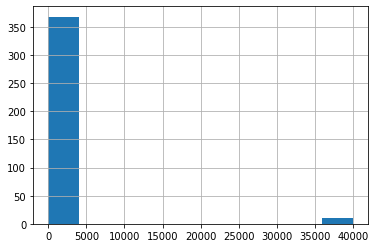

In [ ]:
df_sample_2['difference_1'].hist()

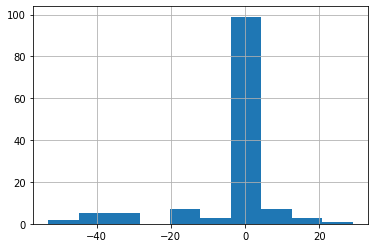

In [ ]:
df_sample_3['difference_2'].hist()

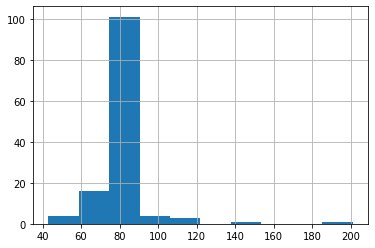

In [ ]:
df_sample_4['difference_3'].hist()

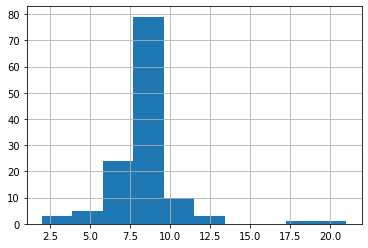

In [ ]:
df_sample_5['difference_4'].hist()

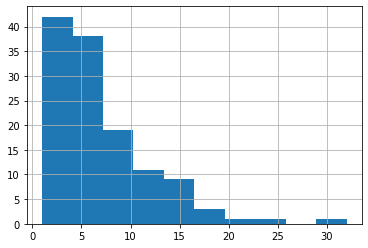

In [ ]:
df_sample_6['difference_5'].hist()

In [ ]:
df_final=df_dropped_resetIdx.copy()

In [ ]:
count=0
for i,j in enumerate(df_final['MCIn1']):
    if i == len(df_final['MCIn1']) - conwip:
        break
    
    if (df_final['MCIn1'][i+conwip] != 0):
        if (df_final['MCOut3'][i] + df_sort_mcout3['MC3Prtime'][i] + 2) > (df_final['MCIn1'][i+conwip]):
            count +=1 
            print(i,'행 m3out과',i+20,'행m1in 확인 바람')
            print(count,'개 (count)')
            print('-'*20)

In [ ]:
df_final.to_csv('/content/gdrive/My Drive/05031-가공전.csv')

# 데이터 가공

* 결측치 처리된 데이터를 통해 시간별 제품위치 파악

In [ ]:
df_completed=df_dropped_resetIdx.copy()
df_completed.head()

,id,Uid,completed,CycleNumber,MCIn1,MC1Prtime,MCOut1,MCIn2,MC2Prtime,MCOut2,MCIn3,MC3Prtime,MCOut3
0,623,c37b877b,0,5,45741.99996,0.26,45764.49996,45767.49996,3.19,45843.99996,45851.99996,11.52,0.0
1,292,c37b7dfe,0,3,0.00000,0.39,0.00000,0.00000,6.95,0.00000,0.00000,4.22,0.0
2,347,c37b770b,0,3,0.00000,2.41,0.00000,0.00000,3.60,0.00000,0.00000,2.68,0.0
3,364,c37ba2e1,0,3,45612.00003,4.18,45644.99999,45647.99997,0.71,45675.99996,0.00000,2.71,0.0
4,422,c37b9987,0,4,45778.99998,1.84,45801.49998,45804.49998,5.40,45880.99998,45888.99998,14.98,0.0


In [ ]:
totalTime=[]
for i in df_completed['MCIn1']:
    totalTime.append(i)
len(totalTime)

385

In [ ]:
# 데이터 받고 돌려볼 로직
#12시31분 -> 12시50분
#timeData = 51534
#m1_buffer , m1m2, m2buffer, m2m3, m3buffer = 0, 0, 0, 0, 0

conwip = 20

list2=[]

m1_buffer_list =[]
m1m2_list =[]
m2buffer_list =[]
m2m3_list =[]
m3buffer_list =[]
inm1_list = []
#ct_list=[]
count_3=1


total2=[]

for timeData in totalTime:
    m1_buffer , m1m2, m2buffer, m2m3, m3buffer, inm1 = 0, 0, 0, 0, 0, 0
    #ct_idx=0
    #ct=0
    m1_buffer_list_prod =[]
    m1m2_list_prod =[]
    m2buffer_list_prod =[]
    m2m3_list_prod =[]
    m3buffer_list_prod =[]
    inm1_list_prod = []
    total1=[]

    
    print('-'*30)
    print(timeData,'파이팅!:',count_3)
    for i, j in enumerate(df_completed['MCIn1']):
        if (timeData > df_completed.loc[[i],['MCIn1']]).bool() & (timeData < df_completed.loc[[i],['MCOut1']]).bool():
            m1_buffer +=1
            m1_buffer_list_prod.append(df_completed['Uid'][i])

            #ct_idx=i
        elif (timeData > df_completed.loc[[i],['MCOut1']]).bool() & (timeData < df_completed.loc[[i],['MCIn2']]).bool():
            m1m2 +=1
            m1m2_list_prod.append(df_completed['Uid'][i])

            #ct_idx=i
        elif (timeData > df_completed.loc[[i],['MCIn2']]).bool() & (timeData < df_completed.loc[[i],['MCOut2']]).bool():
            m2buffer +=1
            m2buffer_list_prod.append(df_completed['Uid'][i])

            #ct_idx=i
        elif (timeData > df_completed.loc[[i],['MCOut2']]).bool() & (timeData < df_completed.loc[[i],['MCIn3']]).bool():
            m2m3 +=1
            m2m3_list_prod.append(df_completed['Uid'][i])

            #ct_idx=i
        elif (timeData > df_completed.loc[[i],['MCIn3']]).bool() & (timeData < df_completed.loc[[i],['MCOut3']]).bool():
            m3buffer +=1
            m3buffer_list_prod.append(df_completed['Uid'][i])

            #ct_idx=i
            
    total1.append(m1_buffer_list_prod)
    total1.append(m1m2_list_prod)
    total1.append(m2buffer_list_prod)
    total1.append(m2m3_list_prod)
    total1.append(m3buffer_list_prod)
    total2.append(total1)

    #ct = df_completed.loc[[ct_idx],['m3ouT']] - df_completed.loc[[ct_idx],['m1iN']]
    #ct = df_completed.iloc[ct_idx+1, 5] - df_completed.iloc[ct_idx+1, 0] #자리위치로 연산

    inm1 = conwip - (m1_buffer + m1m2 + m2buffer + m2m3 + m3buffer)
    
    m1_buffer_list.append(m1_buffer)
    m1m2_list.append(m1m2)
    m2buffer_list.append(m2buffer)
    m2m3_list.append(m2m3)
    m3buffer_list.append(m3buffer)
    inm1_list.append(inm1)
    #ct_list.append(ct)
    
    count_3+=1
    
df_3 = pd.DataFrame({'Time': totalTime,
                     'inm1':inm1_list,
                     'm1_buffer':m1_buffer_list,
                     'm1m2':m1m2_list,
                     'm2buffer':m2buffer_list,
                     'm2m3':m2m3_list,
                     'm3buffer':m3buffer_list,
                     'total': total2
                     
                     #'CycleTime':ct_list
                      })

------------------------------
45741.99996 파이팅!: 1
------------------------------
0.0 파이팅!: 2
------------------------------
0.0 파이팅!: 3
------------------------------
45612.00003 파이팅!: 4
------------------------------
45778.99998 파이팅!: 5
------------------------------
0.0 파이팅!: 6
------------------------------
45709.00001 파이팅!: 7
------------------------------
0.0 파이팅!: 8
------------------------------
45555.49997 파이팅!: 9
------------------------------
0.0 파이팅!: 10
------------------------------
39598.99996 파이팅!: 11
------------------------------
39606.00001 파이팅!: 12
------------------------------
39625.00002 파이팅!: 13
------------------------------
39660.00001 파이팅!: 14
------------------------------
39668.00001 파이팅!: 15
------------------------------
39683.00003 파이팅!: 16
------------------------------
39706.99996 파이팅!: 17
------------------------------
39719.00003 파이팅!: 18
------------------------------
0.0 파이팅!: 19
------------------------------
0.0 파이팅!: 20
-------------------------

In [ ]:
import pickle
import pandas as pd

temp = df_3.copy()

# 데이터 저장
temp.to_pickle('/content/gdrive/My Drive/05031-가공후.pkl')
temp.to_excel('/content/gdrive/My Drive/05031-가공후.xlsx')

In [ ]:
import pickle

# 파일 읽기 시엔 rb 모드

with open('/content/gdrive/My Drive/05011-가공후.pkl', 'rb') as f:

    df_3 = pickle.load(f)
df_3.head()

,Time,inm1,m1_buffer,m1m2,m2buffer,m2m3,m3buffer,total
0,0.000000,20,0,0,0,0,0,"[[], [], [], [], []]"
1,73823.999962,9,1,0,9,1,0,"[[c37b877b], [], [c37b7970, c37b9e2f, c37b9987..."
2,73857.000010,9,2,0,8,1,0,"[[c37b75d8, c37b9aab], [], [c37b9728, c37b7970..."
3,0.000000,20,0,0,0,0,0,"[[], [], [], [], []]"
4,73735.000013,5,7,0,5,2,1,"[[c37b75d8, c37b9987, c37b9aab, c37b997a, c37b..."


In [ ]:
df_3.head(150)

,Time,inm1,m1_buffer,m1m2,m2buffer,m2m3,m3buffer,total
0,0.000000,20,0,0,0,0,0,"[[], [], [], [], []]"
1,73823.999962,9,1,0,9,1,0,"[[c37b877b], [], [c37b7970, c37b9e2f, c37b9987..."
2,73857.000010,9,2,0,8,1,0,"[[c37b75d8, c37b9aab], [], [c37b9728, c37b7970..."
3,0.000000,20,0,0,0,0,0,"[[], [], [], [], []]"
4,73735.000013,5,7,0,5,2,1,"[[c37b75d8, c37b9987, c37b9aab, c37b997a, c37b..."
5,73897.000013,15,0,0,4,1,0,"[[], [], [c37b9728, c37b7970, c37b84f4, c37b87..."
6,0.000000,20,0,0,0,0,0,"[[], [], [], [], []]"
7,0.000000,20,0,0,0,0,0,"[[], [], [], [], []]"
8,73632.999974,0,9,0,9,2,0,"[[c37b9987, c37b9aab, c37b997a, c37b81a9, c37b..."
9,0.000000,20,0,0,0,0,0,"[[], [], [], [], []]"


In [ ]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Time       144 non-null    float64
 1   inm1       144 non-null    int64  
 2   m1_buffer  144 non-null    int64  
 3   m1m2       144 non-null    int64  
 4   m2buffer   144 non-null    int64  
 5   m2m3       144 non-null    int64  
 6   m3buffer   144 non-null    int64  
 7   total      144 non-null    object 
dtypes: float64(1), int64(6), object(1)
memory usage: 9.1+ KB


In [ ]:
df_3.to_csv('df-table6-conwip20-0427-2등호x-가공된파일.csv')
df_3.head(500)

,Time,inm1,m1_buffer,m1m2,m2buffer,m2m3,m3buffer
0,35990,13,2,0,4,1,0
1,36012,12,4,0,4,0,0
2,36028,11,5,0,3,1,0
3,36032,10,6,0,3,0,1
4,36048,10,7,0,3,0,0
5,36082,7,8,0,4,1,0
6,36129,5,8,0,4,1,2
7,36137,6,8,0,4,0,2
8,36140,6,9,0,4,0,1
9,36161,5,10,0,3,1,1


In [ ]:
df_4 = df_3.copy()
df_4.describe()

,Time,inm1,m1_buffer,m1m2,m2buffer,m2m3,m3buffer
count,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000,144.000000
mean,57947.635000,4.305556,9.152778,0.222222,5.250000,0.611111,0.458333
std,29830.507281,6.116901,4.360213,0.479575,3.291226,0.767442,0.577855
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,72530.502472,1.000000,7.750000,0.000000,3.000000,0.000000,0.000000
50%,73046.390002,1.000000,10.000000,0.000000,6.000000,0.000000,0.000000
75%,73444.717510,3.250000,12.000000,0.000000,8.000000,1.000000,1.000000
max,73904.999962,20.000000,19.000000,3.000000,11.000000,3.000000,2.000000


In [ ]:
# CycletTime 추가

conwip=20

df_3['CycleTime_cycle1'] = 1.1
df_3['CycleTime_cycle2'] = 1.1
df_3['CycleTime_cycle3'] = 1.1
df_3['CycleTime_cycle4'] = 1.1
df_3['CycleTime_cycle5'] = 1.1



for i,j in enumerate(df_3['Time']):
    try :
        df_3['CycleTime_cycle1'][i] = df_3['Time'][i+conwip] -j
    except :
        pass
    
for i,j in enumerate(df_3['Time']):
    try :
        df_3['CycleTime_cycle2'][i] = df_3['Time'][i+conwip*2] -j
    except :
        pass
    
for i,j in enumerate(df_3['Time']):
    try :
        df_3['CycleTime_cycle3'][i] = df_3['Time'][i+conwip*3] -j
    except :
        pass
    
for i,j in enumerate(df_3['Time']):
    try :
        df_3['CycleTime_cycle4'][i] = df_3['Time'][i+conwip*4] -j
    except:
        pass
    
for i,j in enumerate(df_3['Time']):
    try :
        df_3['CycleTime_cycle5'][i] = df_3['Time'][i+conwip*5] -j
    except :
        pass



In [ ]:
df_3

,Time,inm1,m1_buffer,m1m2,m2buffer,m2m3,m3buffer,total,CycleTime_cycle1,CycleTime_cycle2,CycleTime_cycle3,CycleTime_cycle4,CycleTime_cycle5
0,0.000000,20,0,0,0,0,0,"[[], [], [], [], []]",5.000000,72470.230026,72814.099990,73031.919971,73295.820042
1,73823.999962,9,1,0,9,1,0,"[[c37b877b], [], [c37b7970, c37b9e2f, c37b9987...",-73820.689962,-1337.059965,-999.309968,-761.569946,-530.279952
2,73857.000010,9,2,0,8,1,0,"[[c37b75d8, c37b9aab], [], [c37b9728, c37b7970...",-73853.850010,-1354.040022,-1018.640019,-796.139978,-553.750045
3,0.000000,20,0,0,0,0,0,"[[], [], [], [], []]",5.030000,72507.970029,72859.839974,73081.320010,73325.740010
4,73735.000013,5,7,0,5,2,1,"[[c37b75d8, c37b9987, c37b9aab, c37b997a, c37b...",-73726.420013,-1218.830029,-874.769984,-634.670000,-410.980022
5,73897.000013,15,0,0,4,1,0,"[[], [], [c37b9728, c37b7970, c37b84f4, c37b87...",-73890.050013,-1361.720045,-1028.550022,-791.839990,-565.949981
6,0.000000,20,0,0,0,0,0,"[[], [], [], [], []]",3.120000,72574.700035,72876.880000,73111.099965,73346.640042
7,0.000000,20,0,0,0,0,0,"[[], [], [], [], []]",3.040000,72593.940006,72888.300022,73125.349981,73355.000026
8,73632.999974,0,9,0,9,2,0,"[[c37b9987, c37b9aab, c37b997a, c37b81a9, c37b...",-73628.519974,-1019.650013,-738.159990,-499.529965,-271.429955
9,0.000000,20,0,0,0,0,0,"[[], [], [], [], []]",6.390000,72625.399990,72896.839965,73151.379981,73368.729974


In [ ]:
import pickle
import pandas as pd

temp = df_3.copy()

# 데이터 저장
temp.to_pickle('/content/gdrive/My Drive/05011-가공후-ct.pkl')
temp.to_excel('/content/gdrive/My Drive/05011-가공후-ct.xlsx')